In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Data Processing

### Crime

Download NYPD complaints data with curl

Data dictionary: https://data.cityofnewyork.us/api/views/qgea-i56i/files/b21ec89f-4d7b-494e-b2e9-f69ae7f4c228?download=true&filename=NYPD_Complaint_Incident_Level_Data_Footnotes.pdf

In [2]:
crime_data = pd.read_csv('data/NYPD_Complaint_Data_Historic.csv')

crime_data.head()

/var/folders/78/73hgkmn13jjcw_dhfbc0tf4h0000gn/T/ipykernel_37140/1633648925.py:1: DtypeWarning: Columns (0,20) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_data = pd.read_csv('data/NYPD_Complaint_Data_Historic.csv')


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,39468181,02/20/2008,07:00:00,02/23/2008,08:00:00,88.0,02/23/2008,107,BURGLARY,221.0,...,(null),NaN,40.692464,-73.972708,"(40.692464, -73.972708)",PATROL BORO BKLYN NORTH,(null),25-44,WHITE,F
1,50539499,08/21/2008,22:00:00,08/21/2008,23:00:00,19.0,08/22/2008,109,GRAND LARCENY,438.0,...,(null),NaN,40.771341,-73.953418,"(40.771341, -73.953418)",PATROL BORO MAN NORTH,(null),45-64,WHITE HISPANIC,F
2,45223390,04/03/2008,03:35:00,04/03/2008,03:50:00,77.0,04/03/2008,106,FELONY ASSAULT,109.0,...,(null),NaN,40.671245,-73.926713,"(40.671245, -73.926713)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
3,50594658,08/19/2008,09:00:00,NaN,(null),32.0,08/27/2008,341,PETIT LARCENY,349.0,...,(null),NaN,40.813412,-73.943226,"(40.813412, -73.943226)",PATROL BORO MAN NORTH,(null),(null),UNKNOWN,M
4,44451016,03/10/2008,22:00:00,03/10/2008,22:10:00,67.0,03/11/2008,105,ROBBERY,397.0,...,M,NaN,40.650142,-73.944674,"(40.650142, -73.944674)",PATROL BORO BKLYN SOUTH,(null),25-44,BLACK,M


In [3]:
crime_data.shape

(9491946, 35)

In [4]:
crime_data.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT',
       'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME',
       'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'],
      dtype='object')

The complete data dictionary link is provided above. The focus of this notebook would be on columns - 'CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'OFNS_DESC', 'BORO_NM', 'Latitude', 'Longitude'.

The 'CMPLNT_NUM' is a unique id for each complaint, 'CMPLNT_FR_DT' and 'CMPLNT_FR_TM' are date and time of complaint respectively, 'OFNS_DESC' is the type of offence reported, 'BORO_NM' is name of borough where complaint was reported, and 'Latitude', 'Longitude' are location of complaint.

#### filter out missing/wrong date and times, missing borough name and duplicate complaints from the data

In [5]:
crime_data.isna().sum()

CMPLNT_NUM                 0
CMPLNT_FR_DT             655
CMPLNT_FR_TM               0
CMPLNT_TO_DT         1848434
CMPLNT_TO_TM               0
ADDR_PCT_CD              771
RPT_DT                     0
KY_CD                      0
OFNS_DESC                  0
PD_CD                   7975
PD_DESC                    0
CRM_ATPT_CPTD_CD           0
LAW_CAT_CD                 0
BORO_NM                    0
LOC_OF_OCCUR_DESC        234
PREM_TYP_DESC              0
JURIS_DESC                 0
JURISDICTION_CODE          0
PARKS_NM                   0
HADEVELOPT                 0
HOUSING_PSA           541632
X_COORD_CD               475
Y_COORD_CD               475
SUSP_AGE_GROUP             0
SUSP_RACE                  0
SUSP_SEX                   0
TRANSIT_DISTRICT     9266722
Latitude                 479
Longitude                479
Lat_Lon                  479
PATROL_BORO                0
STATION_NAME               0
VIC_AGE_GROUP              0
VIC_RACE                   0
VIC_SEX       

In [6]:
crime_data['CMPLNT_FR_DT'] = pd.to_datetime(crime_data['CMPLNT_FR_DT'], errors='coerce')
crime_data['CMPLNT_FR_TM'] = pd.to_datetime(crime_data['CMPLNT_FR_TM'], format='%H:%M:%S', errors='coerce').dt.time

print(crime_data.CMPLNT_FR_DT.isna().sum())
print(crime_data.CMPLNT_FR_TM.isna().sum())

853
48


In [7]:
crime_data.dropna(subset=['CMPLNT_FR_DT', 'CMPLNT_FR_TM'], inplace=True)
crime_data.shape

(9491046, 35)

In [8]:
crime_data.drop_duplicates(subset=['CMPLNT_NUM'], inplace=True)
crime_data.shape

(9489987, 35)

In [9]:
crime_data.BORO_NM.unique()

array(['BROOKLYN', 'MANHATTAN', 'BRONX', 'QUEENS', '(null)',
       'STATEN ISLAND'], dtype=object)

In [10]:
crime_data = crime_data[~crime_data.BORO_NM.isna()]
crime_data = crime_data[crime_data.BORO_NM != '(null)']
crime_data.shape

(9481269, 35)

In [11]:
crime_data.BORO_NM.unique()

array(['BROOKLYN', 'MANHATTAN', 'BRONX', 'QUEENS', 'STATEN ISLAND'],
      dtype=object)

#### filter data for 2020 and after

In [12]:
## check the timeline of data
print(crime_data.sort_values(by='CMPLNT_FR_DT', ascending=True).head(3)['CMPLNT_FR_DT'])
print(crime_data.sort_values(by='CMPLNT_FR_DT', ascending=False).head(3)['CMPLNT_FR_DT'])

7836445   1900-03-10
563623    1900-05-08
6810745   1900-06-02
Name: CMPLNT_FR_DT, dtype: datetime64[ns]
9059692   2024-12-31
8989087   2024-12-31
9487643   2024-12-31
Name: CMPLNT_FR_DT, dtype: datetime64[ns]


In [13]:
crime_filtered = crime_data[crime_data.CMPLNT_FR_DT >= '2022-01-01']

In [14]:
print(crime_filtered.sort_values(by='CMPLNT_FR_DT', ascending=True).head(1)['CMPLNT_FR_DT'].values[0])
print(crime_filtered.sort_values(by='CMPLNT_FR_DT', ascending=False).head(1)['CMPLNT_FR_DT'].values[0])

2022-01-01T00:00:00.000000000
2024-12-31T00:00:00.000000000


In [15]:
crime_filtered.shape

(1645492, 35)

#### keep Violent Crimes and Property Crimes as defined by FBI from the data :
https://ucr.fbi.gov/crime-in-the-u.s/2019/crime-in-the-u.s.-2019/topic-pages/offenses-known-to-law-enforcement

The crime type is present in the 'OFNS_DESC' column. We just keep the following categories:

**Violent Crime:**
'MURDER & NON-NEGL. MANSLAUGHTER',
'RAPE',
'ROBBERY',
'FELONY ASSAULT'

**Property Crime:**
'BURGLARY',
'GRAND LARCENY' ,'PETIT LARCENY',
'GRAND LARCENY OF MOTOR VEHICLE', 'PETIT LARCENY OF MOTOR VEHICLE',
'ARSON'


In [16]:
crime_filtered.OFNS_DESC.unique()

array(['RAPE', 'BURGLARY', 'ROBBERY', 'HARRASSMENT 2', 'FELONY ASSAULT',
       'DANGEROUS WEAPONS', 'ASSAULT 3 & RELATED OFFENSES',
       'PETIT LARCENY', 'GRAND LARCENY', 'VEHICLE AND TRAFFIC LAWS',
       'OFF. AGNST PUB ORD SENSBLTY &', 'MISCELLANEOUS PENAL LAW',
       'CRIMINAL MISCHIEF & RELATED OF', 'THEFT-FRAUD', 'DANGEROUS DRUGS',
       "BURGLAR'S TOOLS", 'CRIMINAL TRESPASS',
       'MURDER & NON-NEGL. MANSLAUGHTER',
       'GRAND LARCENY OF MOTOR VEHICLE', 'FORGERY',
       'OFFENSES INVOLVING FRAUD', 'POSSESSION OF STOLEN PROPERTY',
       'SEX CRIMES', 'OFFENSES AGAINST PUBLIC ADMINI', 'FRAUDS',
       'OTHER STATE LAWS (NON PENAL LA', 'OFFENSES AGAINST PUBLIC SAFETY',
       'ADMINISTRATIVE CODE', 'OTHER STATE LAWS',
       'NYS LAWS-UNCLASSIFIED FELONY', 'FRAUDULENT ACCOSTING',
       'ENDAN WELFARE INCOMP', 'AGRICULTURE & MRKTS LAW-UNCLASSIFIED',
       'CANNABIS RELATED OFFENSES', 'KIDNAPPING & RELATED OFFENSES',
       'INTOXICATED & IMPAIRED DRIVING', 'ESCAPE 3',
 

In [17]:
crime_filtered = crime_filtered[crime_filtered.OFNS_DESC.isin([ 'MURDER & NON-NEGL. MANSLAUGHTER', 'RAPE', 'ROBBERY', 'FELONY ASSAULT',
                          'BURGLARY', 'GRAND LARCENY' ,'PETIT LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE', 'PETIT LARCENY OF MOTOR VEHICLE', 'ARSON'])]
crime_filtered.reset_index(drop=True, inplace=True)
crime_filtered.shape

(705945, 35)

In [18]:
crime_filtered.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,242132877,2022-02-07,14:30:00,NaN,(null),44.0,03/15/2022,104,RAPE,153.0,...,F,NaN,40.837842,-73.919628,"(40.8378421209284, -73.9196277517392)",PATROL BORO BRONX,(null),<18,BLACK,F
1,242306354,2022-03-14,17:50:00,NaN,(null),44.0,03/18/2022,107,BURGLARY,241.0,...,M,NaN,40.822622,-73.930942,"(40.822622, -73.930942)",PATROL BORO BRONX,(null),45-64,WHITE,F
2,247060032,2022-06-23,10:10:00,06/23/2022,10:13:00,60.0,06/23/2022,105,ROBBERY,361.0,...,M,NaN,40.577312,-73.962821,"(40.577312, -73.962821)",PATROL BORO BKLYN SOUTH,(null),UNKNOWN,UNKNOWN,D
3,248149060,2022-07-17,20:11:00,NaN,(null),73.0,07/17/2022,106,FELONY ASSAULT,109.0,...,U,NaN,40.662554,-73.908920,"(40.6625545, -73.9089197)",PATROL BORO BKLYN NORTH,(null),18-24,UNKNOWN,M
4,262255016,2023-01-20,02:00:00,01/20/2023,02:30:00,43.0,01/21/2023,104,RAPE,157.0,...,M,NaN,40.822912,-73.870041,"(40.8229123084767, -73.8700413043181)",PATROL BORO BRONX,(null),18-24,WHITE HISPANIC,F


In [19]:
crime_filtered = crime_filtered[['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM','OFNS_DESC','BORO_NM',
                                 'X_COORD_CD', 'Y_COORD_CD','Latitude', 'Longitude', 'Lat_Lon']]

crime_filtered.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,OFNS_DESC,BORO_NM,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,242132877,2022-02-07,14:30:00,RAPE,BRONX,1006490.0,244533.0,40.837842,-73.919628,"(40.8378421209284, -73.9196277517392)"
1,242306354,2022-03-14,17:50:00,BURGLARY,BRONX,1003363.0,238988.0,40.822622,-73.930942,"(40.822622, -73.930942)"
2,247060032,2022-06-23,10:10:00,ROBBERY,BROOKLYN,994577.0,149608.0,40.577312,-73.962821,"(40.577312, -73.962821)"
3,248149060,2022-07-17,20:11:00,FELONY ASSAULT,BROOKLYN,1009519.0,180676.0,40.662554,-73.908920,"(40.6625545, -73.9089197)"
4,262255016,2023-01-20,02:00:00,RAPE,BRONX,1020219.0,239110.0,40.822912,-73.870041,"(40.8229123084767, -73.8700413043181)"


In [20]:
violent_crimes = ['MURDER & NON-NEGL. MANSLAUGHTER', 'RAPE', 'FELONY ASSAULT']
property_crimes = ['ROBBERY', 'BURGLARY', 'GRAND LARCENY', 'PETIT LARCENY', 
                  'GRAND LARCENY OF MOTOR VEHICLE', 'PETIT LARCENY OF MOTOR VEHICLE', 'ARSON']

# add crime category labels
crime_filtered['crime_category'] = 'other'
crime_filtered.loc[crime_filtered.OFNS_DESC.isin(violent_crimes), 'crime_category'] = 'violent'
crime_filtered.loc[crime_filtered.OFNS_DESC.isin(property_crimes), 'crime_category'] = 'property'
crime_filtered.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,OFNS_DESC,BORO_NM,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,crime_category
0,242132877,2022-02-07,14:30:00,RAPE,BRONX,1006490.0,244533.0,40.837842,-73.919628,"(40.8378421209284, -73.9196277517392)",violent
1,242306354,2022-03-14,17:50:00,BURGLARY,BRONX,1003363.0,238988.0,40.822622,-73.930942,"(40.822622, -73.930942)",property
2,247060032,2022-06-23,10:10:00,ROBBERY,BROOKLYN,994577.0,149608.0,40.577312,-73.962821,"(40.577312, -73.962821)",property
3,248149060,2022-07-17,20:11:00,FELONY ASSAULT,BROOKLYN,1009519.0,180676.0,40.662554,-73.908920,"(40.6625545, -73.9089197)",violent
4,262255016,2023-01-20,02:00:00,RAPE,BRONX,1020219.0,239110.0,40.822912,-73.870041,"(40.8229123084767, -73.8700413043181)",violent


In [ ]:
# Ensure that the date and time columns are of string type
crime_filtered['CMPLNT_FR_DT'] = crime_filtered['CMPLNT_FR_DT'].astype(str)
crime_filtered['CMPLNT_FR_TM'] = crime_filtered['CMPLNT_FR_TM'].astype(str)

# Combine the date and time columns into a single datetime column
crime_filtered['datetime'] = pd.to_datetime(
    crime_filtered['CMPLNT_FR_DT'] + ' ' + crime_filtered['CMPLNT_FR_TM'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'  # Invalid formats will be set as NaT (Not a Time)
)

# Extract basic time-based features from the datetime column
crime_filtered['year'] = crime_filtered['datetime'].dt.year
crime_filtered['month'] = crime_filtered['datetime'].dt.month
crime_filtered['day'] = crime_filtered['datetime'].dt.day
crime_filtered['hour'] = crime_filtered['datetime'].dt.hour
crime_filtered['dayofweek'] = crime_filtered['datetime'].dt.dayofweek  # Monday=0, Sunday=6
crime_filtered['is_weekend'] = crime_filtered['dayofweek'].isin([5, 6]).astype(int)  # 1 for Saturday/Sunday, 0 otherwise

In [22]:
crime_filtered.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,OFNS_DESC,BORO_NM,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,crime_category,datetime,year,month,day,hour,dayofweek,is_weekend
0,242132877,2022-02-07,14:30:00,RAPE,BRONX,1006490.0,244533.0,40.837842,-73.919628,"(40.8378421209284, -73.9196277517392)",violent,2022-02-07 14:30:00,2022,2,7,14,0,0
1,242306354,2022-03-14,17:50:00,BURGLARY,BRONX,1003363.0,238988.0,40.822622,-73.930942,"(40.822622, -73.930942)",property,2022-03-14 17:50:00,2022,3,14,17,0,0
2,247060032,2022-06-23,10:10:00,ROBBERY,BROOKLYN,994577.0,149608.0,40.577312,-73.962821,"(40.577312, -73.962821)",property,2022-06-23 10:10:00,2022,6,23,10,3,0
3,248149060,2022-07-17,20:11:00,FELONY ASSAULT,BROOKLYN,1009519.0,180676.0,40.662554,-73.908920,"(40.6625545, -73.9089197)",violent,2022-07-17 20:11:00,2022,7,17,20,6,1
4,262255016,2023-01-20,02:00:00,RAPE,BRONX,1020219.0,239110.0,40.822912,-73.870041,"(40.8229123084767, -73.8700413043181)",violent,2023-01-20 02:00:00,2023,1,20,2,4,0


In [23]:
crime_filtered = crime_filtered[['CMPLNT_NUM', 'datetime','OFNS_DESC','crime_category','BORO_NM', 'Latitude', 'Longitude', 
                                 'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend']]

In [24]:
crime_gdf = gpd.GeoDataFrame(
    crime_filtered, 
    geometry=gpd.points_from_xy(crime_filtered.Longitude, crime_filtered.Latitude),
    crs="EPSG:4326"
    )

crime_gdf = crime_gdf.to_crs("EPSG:2263")

In [25]:
crime_gdf.head()

,CMPLNT_NUM,datetime,OFNS_DESC,crime_category,BORO_NM,Latitude,Longitude,year,month,day,hour,dayofweek,is_weekend,geometry
0,242132877,2022-02-07 14:30:00,RAPE,violent,BRONX,40.837842,-73.919628,2022,2,7,14,0,0,POINT (1006489.602 244536.018)
1,242306354,2022-03-14 17:50:00,BURGLARY,property,BRONX,40.822622,-73.930942,2022,3,14,17,0,0,POINT (1003363.237 238988.1)
2,247060032,2022-06-23 10:10:00,ROBBERY,property,BROOKLYN,40.577312,-73.962821,2022,6,23,10,3,0,POINT (994577.995 149608.961)
3,248149060,2022-07-17 20:11:00,FELONY ASSAULT,violent,BROOKLYN,40.662554,-73.908920,2022,7,17,20,6,1,POINT (1009519.001 180675.998)
4,262255016,2023-01-20 02:00:00,RAPE,violent,BRONX,40.822912,-73.870041,2023,1,20,2,4,0,POINT (1020218.605 239113.017)


In [26]:
crime_gdf.to_csv('processed_data/crime_gdf.csv', index= False)

### MTA

#### Route

In [27]:
routes = gpd.read_file('data/subway_routes/subwaylines')
routes.head()

,id,name,objectid,rt_symbol,shape_len,url,geometry
0,2000393.0,G,753.0,G,2438.200249,http://web.mta.info/nyct/service/,"LINESTRING (-73.99488 40.6802, -73.99427 40.68..."
1,2000394.0,G,754.0,G,3872.834411,http://web.mta.info/nyct/service/,"LINESTRING (-73.97958 40.65993, -73.97966 40.6..."
2,2000469.0,Q,755.0,N,1843.366331,http://web.mta.info/nyct/service/,"LINESTRING (-73.97586 40.57597, -73.97654 40.5..."
3,2000294.0,M,756.0,B,1919.559203,http://web.mta.info/nyct/service/,"LINESTRING (-73.92414 40.75229, -73.92405 40.7..."
4,2000296.0,M,757.0,B,2385.698536,http://web.mta.info/nyct/service/,"LINESTRING (-73.91345 40.75617, -73.90905 40.7..."


In [28]:
complement = gpd.read_file('data/subway_routes/complement_line')
complement.head()

,route_id,route_shor,route_long,group_,SymbolID,Shape_Leng,geometry
0,SI,SIR,Staten Island Railway,SIR,None,30364.614887,"LINESTRING (-8265691 4940739, -8265527 4940876..."


In [29]:
complement = complement.rename(columns={'route_id': 'id', 
                                     'route_shor': 'name', 
                                     'group_': 'objectid',
                                     'SymbolID': 'rt_symbol',
                                     'Shape_Leng': 'shape_len',
                                     'route_long': 'url'})

complement = complement.to_crs("EPSG:2263")
complement.head()

,id,name,url,objectid,rt_symbol,shape_len,geometry
0,SI,SIR,Staten Island Railway,SIR,None,30364.614887,"LINESTRING (914188.662 126193.802, 914599.283 ..."


In [30]:
routes = routes.to_crs("EPSG:2263")

routes = pd.concat([routes, complement], ignore_index=True)

routes.head()

,id,name,objectid,rt_symbol,shape_len,url,geometry
0,2000393.0,G,753.0,G,2438.200249,http://web.mta.info/nyct/service/,"LINESTRING (985671.417 187092.953, 985837.975 ..."
1,2000394.0,G,754.0,G,3872.834411,http://web.mta.info/nyct/service/,"LINESTRING (989916.745 179707.597, 989894.632 ..."
2,2000469.0,Q,755.0,N,1843.366331,http://web.mta.info/nyct/service/,"LINESTRING (990957.018 149120.411, 990766.5 14..."
3,2000294.0,M,756.0,B,1919.559203,http://web.mta.info/nyct/service/,"LINESTRING (1005267.038 213365.645, 1005293.11..."
4,2000296.0,M,757.0,B,2385.698536,http://web.mta.info/nyct/service/,"LINESTRING (1008229.303 214782.238, 1009448.37..."


In [31]:
routes = routes[['name', 'objectid', 'shape_len','geometry']]
routes.head()

,name,objectid,shape_len,geometry
0,G,753.0,2438.200249,"LINESTRING (985671.417 187092.953, 985837.975 ..."
1,G,754.0,3872.834411,"LINESTRING (989916.745 179707.597, 989894.632 ..."
2,Q,755.0,1843.366331,"LINESTRING (990957.018 149120.411, 990766.5 14..."
3,M,756.0,1919.559203,"LINESTRING (1005267.038 213365.645, 1005293.11..."
4,M,757.0,2385.698536,"LINESTRING (1008229.303 214782.238, 1009448.37..."


#### Station

In [32]:
subway_stations = pd.read_csv('data/MTA_Subway_Stations.csv')
subway_stations.head()

,GTFS Stop ID,Station ID,Complex ID,Division,Line,Stop Name,Borough,CBD,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Northbound,ADA Southbound,ADA Notes,Georeference
0,R01,1,1,BMT,Astoria,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,Last Stop,Manhattan,0,0,0,NaN,POINT (-73.912034 40.775036)
1,R03,2,2,BMT,Astoria,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,Astoria,Manhattan,1,1,1,NaN,POINT (-73.917843 40.770258)
2,R04,3,3,BMT,Astoria,30 Av,Q,False,N W,Elevated,40.766779,-73.921479,Astoria,Manhattan,0,0,0,NaN,POINT (-73.921479 40.766779)
3,R05,4,4,BMT,Astoria,Broadway,Q,False,N W,Elevated,40.761820,-73.925508,Astoria,Manhattan,0,0,0,NaN,POINT (-73.925508 40.76182)
4,R06,5,5,BMT,Astoria,36 Av,Q,False,N W,Elevated,40.756804,-73.929575,Astoria,Manhattan,0,0,0,NaN,POINT (-73.929575 40.756804)


In [33]:
subway_stations.columns

Index(['GTFS Stop ID', 'Station ID', 'Complex ID', 'Division', 'Line',
       'Stop Name', 'Borough', 'CBD', 'Daytime Routes', 'Structure',
       'GTFS Latitude', 'GTFS Longitude', 'North Direction Label',
       'South Direction Label', 'ADA', 'ADA Northbound', 'ADA Southbound',
       'ADA Notes', 'Georeference'],
      dtype='object')

In [34]:
stations = subway_stations[['Station ID', 'Complex ID','Stop Name', 'Borough', 'CBD', 'Daytime Routes',
                            'Structure', 'GTFS Latitude', 'GTFS Longitude', 'Georeference']]
stations.rename(columns={'GTFS Latitude': 'Latitude', 'GTFS Longitude': 'Longitude'}, inplace=True)

/var/folders/78/73hgkmn13jjcw_dhfbc0tf4h0000gn/T/ipykernel_37140/357052668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations.rename(columns={'GTFS Latitude': 'Latitude', 'GTFS Longitude': 'Longitude'}, inplace=True)


In [35]:
def count_routes(route_str):
    if pd.isna(route_str):
        return 0
    routes = route_str.strip().split()
    return len(routes)

stations['route_count'] = stations['Daytime Routes'].apply(count_routes)

stations.head()

/var/folders/78/73hgkmn13jjcw_dhfbc0tf4h0000gn/T/ipykernel_37140/3735118169.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations['route_count'] = stations['Daytime Routes'].apply(count_routes)


,Station ID,Complex ID,Stop Name,Borough,CBD,Daytime Routes,Structure,Latitude,Longitude,Georeference,route_count
0,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,POINT (-73.912034 40.775036),2
1,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,POINT (-73.917843 40.770258),2
2,3,3,30 Av,Q,False,N W,Elevated,40.766779,-73.921479,POINT (-73.921479 40.766779),2
3,4,4,Broadway,Q,False,N W,Elevated,40.761820,-73.925508,POINT (-73.925508 40.76182),2
4,5,5,36 Av,Q,False,N W,Elevated,40.756804,-73.929575,POINT (-73.929575 40.756804),2


#### Entrance and Exit

In [36]:
Entrance_Exit = pd.read_csv('data/MTA_Subway_Entrances_and_Exits_2024.csv')
Entrance_Exit.head()

,Division,Line,Borough,Stop Name,Complex ID,Constituent Station Name,Station ID,GTFS Stop ID,Daytime Routes,Entrance Type,Entry Allowed,Exit Allowed,Entrance Latitude,Entrance Longitude,entrance_georeference
0,BMT,Astoria,Q,Astoria-Ditmars Blvd,1,Astoria-Ditmars Blvd,1,R01,N W,Stair,YES,YES,40.774937,-73.912345,POINT (-73.9123447 40.7749371)
1,BMT,Astoria,Q,Astoria-Ditmars Blvd,1,Astoria-Ditmars Blvd,1,R01,N W,Stair,YES,YES,40.774809,-73.912162,POINT (-73.9121624 40.7748094)
2,BMT,Astoria,Q,Astoria-Ditmars Blvd,1,Astoria-Ditmars Blvd,1,R01,N W,Stair,YES,YES,40.775172,-73.912058,POINT (-73.9120581 40.775172)
3,BMT,Astoria,Q,Astoria-Ditmars Blvd,1,Astoria-Ditmars Blvd,1,R01,N W,Stair,YES,YES,40.775048,-73.911877,POINT (-73.911877 40.7750479)
4,BMT,Astoria,Q,Astoria-Ditmars Blvd,1,Astoria-Ditmars Blvd,1,R01,N W,Easement - Passage,YES,YES,40.774910,-73.911988,POINT (-73.9119884 40.7749098)


In [37]:
entrance_counts = Entrance_Exit.groupby('Station ID')['Entrance Type'].count().reset_index()
entrance_counts.rename(columns={'Entrance Type': 'entrance_count'}, inplace=True)
entrance_counts.head()

,Station ID,entrance_count
0,1,5
1,2,6
2,3,5
3,4,5
4,5,3


In [38]:
stations['Station ID'] = stations['Station ID'].astype(str)
entrance_counts['Station ID'] = entrance_counts['Station ID'].astype(str)
subway_data = pd.merge(stations,entrance_counts, how='left', on='Station ID')
subway_data.head()

/var/folders/78/73hgkmn13jjcw_dhfbc0tf4h0000gn/T/ipykernel_37140/2882431876.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations['Station ID'] = stations['Station ID'].astype(str)


,Station ID,Complex ID,Stop Name,Borough,CBD,Daytime Routes,Structure,Latitude,Longitude,Georeference,route_count,entrance_count
0,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,POINT (-73.912034 40.775036),2,5.0
1,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,POINT (-73.917843 40.770258),2,6.0
2,3,3,30 Av,Q,False,N W,Elevated,40.766779,-73.921479,POINT (-73.921479 40.766779),2,5.0
3,4,4,Broadway,Q,False,N W,Elevated,40.761820,-73.925508,POINT (-73.925508 40.76182),2,5.0
4,5,5,36 Av,Q,False,N W,Elevated,40.756804,-73.929575,POINT (-73.929575 40.756804),2,3.0


In [39]:
subway_data['entrance_count'] = subway_data['entrance_count'].fillna(0)
subway_data['entrance_count'] = subway_data['entrance_count'].astype(int)

In [40]:
subway_data.head()

,Station ID,Complex ID,Stop Name,Borough,CBD,Daytime Routes,Structure,Latitude,Longitude,Georeference,route_count,entrance_count
0,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,POINT (-73.912034 40.775036),2,5
1,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,POINT (-73.917843 40.770258),2,6
2,3,3,30 Av,Q,False,N W,Elevated,40.766779,-73.921479,POINT (-73.921479 40.766779),2,5
3,4,4,Broadway,Q,False,N W,Elevated,40.761820,-73.925508,POINT (-73.925508 40.76182),2,5
4,5,5,36 Av,Q,False,N W,Elevated,40.756804,-73.929575,POINT (-73.929575 40.756804),2,3


#### Ridership


In [41]:
ridership_2022 = pd.read_csv('data/MTA_Subway_Hourly_Ridership_22.csv')
ridership_2023 = pd.read_csv('data/MTA_Subway_Hourly_Ridership_23.csv')
ridership_2024 = pd.read_csv('data/MTA_Subway_Hourly_Ridership_24.csv')

In [42]:
riderships = pd.concat([ridership_2022, ridership_2023, ridership_2024], ignore_index=True)

In [43]:
riderships.head()

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference,year
0,2022-01-01 00:00:00,subway,65,79 St (D),Brooklyn,omny,OMNY - Full Fare,1,0,40.613503,-74.000610,POINT (-74.00061 40.613503),2022
1,2022-01-01 00:00:00,subway,222,Roosevelt Island (F),Manhattan,metrocard,Metrocard - Full Fare,17,0,40.759144,-73.953260,POINT (-73.95326 40.759144),2022
2,2022-01-01 00:00:00,subway,185,Liberty Av (C),Brooklyn,metrocard,Metrocard - Fair Fare,1,0,40.674540,-73.896545,POINT (-73.896545 40.67454),2022
3,2022-01-01 00:00:00,subway,197,Aqueduct-N Conduit Av (A),Queens,metrocard,Metrocard - Full Fare,2,0,40.668236,-73.834060,POINT (-73.83406 40.668236),2022
4,2022-01-01 00:00:00,subway,2,"Astoria Blvd (N,W)",Queens,metrocard,Metrocard - Full Fare,5,0,40.770260,-73.917850,POINT (-73.91785 40.77026),2022


In [44]:
riderships['date'] = pd.to_datetime(riderships['transit_timestamp'])
riderships['weekday'] = riderships['date'].dt.weekday
riderships['is_weekend'] = riderships['date'].isin([5, 6])
riderships['hour'] = pd.to_datetime(riderships['date']).dt.hour
riderships['date'] = riderships['date'].dt.date

riderships.head()

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference,year,date,weekday,is_weekend,hour
0,2022-01-01 00:00:00,subway,65,79 St (D),Brooklyn,omny,OMNY - Full Fare,1,0,40.613503,-74.000610,POINT (-74.00061 40.613503),2022,2022-01-01,5,False,0
1,2022-01-01 00:00:00,subway,222,Roosevelt Island (F),Manhattan,metrocard,Metrocard - Full Fare,17,0,40.759144,-73.953260,POINT (-73.95326 40.759144),2022,2022-01-01,5,False,0
2,2022-01-01 00:00:00,subway,185,Liberty Av (C),Brooklyn,metrocard,Metrocard - Fair Fare,1,0,40.674540,-73.896545,POINT (-73.896545 40.67454),2022,2022-01-01,5,False,0
3,2022-01-01 00:00:00,subway,197,Aqueduct-N Conduit Av (A),Queens,metrocard,Metrocard - Full Fare,2,0,40.668236,-73.834060,POINT (-73.83406 40.668236),2022,2022-01-01,5,False,0
4,2022-01-01 00:00:00,subway,2,"Astoria Blvd (N,W)",Queens,metrocard,Metrocard - Full Fare,5,0,40.770260,-73.917850,POINT (-73.91785 40.77026),2022,2022-01-01,5,False,0


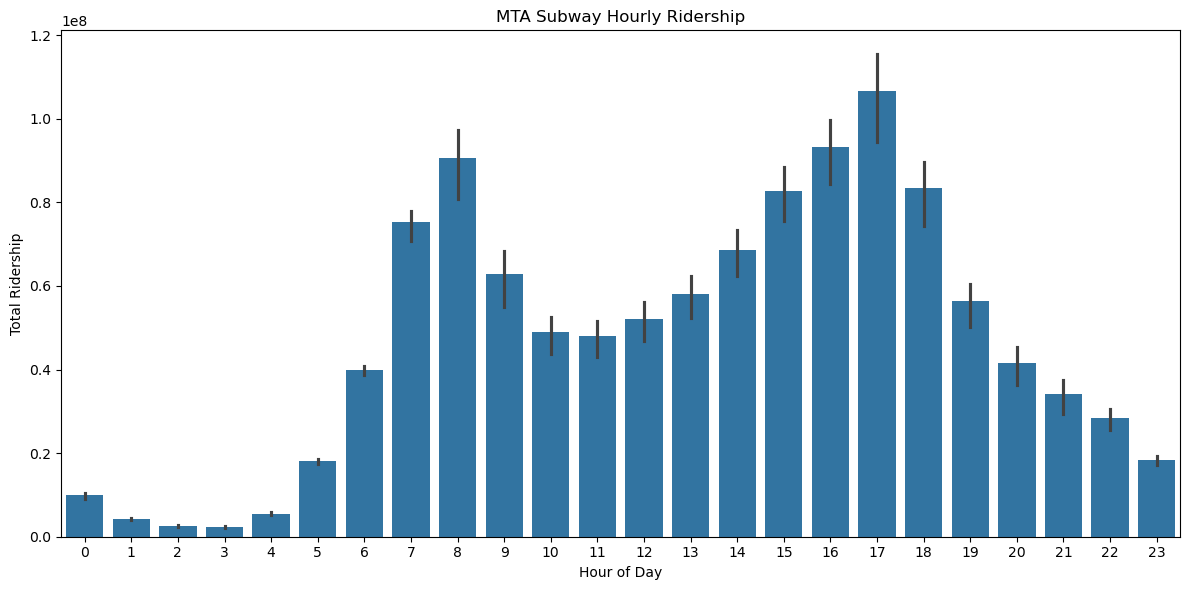

In [45]:
hourly_ridership = riderships.groupby(['year','hour'])['ridership'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='ridership', data=hourly_ridership)

plt.title('MTA Subway Hourly Ridership')
plt.xlabel('Hour of Day')
plt.ylabel('Total Ridership')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

🚆 Peak Hours:

Morning peak: 7 AM to 9 AM — with ridership rising sharply and peaking around 8 AM.

Evening peak: 4 PM to 6 PM — especially 5 PM (17:00), which shows the highest ridership across all hours.

In [46]:
riderships.columns

Index(['transit_timestamp', 'transit_mode', 'station_complex_id',
       'station_complex', 'borough', 'payment_method', 'fare_class_category',
       'ridership', 'transfers', 'latitude', 'longitude', 'Georeference',
       'year', 'date', 'weekday', 'is_weekend', 'hour'],
      dtype='object')

In [47]:
riderships_filtered = riderships.groupby(['station_complex_id','year'])['ridership'].sum().reset_index()
riderships_filtered.head()

,station_complex_id,year,ridership
0,1,2022,3030256
1,1,2023,3287685
2,1,2024,3394788
3,10,2022,4635339
4,10,2023,5523914


In [48]:
riderships_filtered['ridership'].isna().sum()

0

In [49]:
complex_station_counts = subway_data.groupby('Complex ID').size().reset_index(name='stations_in_complex')

multi_station_complexes = complex_station_counts[complex_station_counts['stations_in_complex'] > 1]
print(f"found {len(multi_station_complexes)} multi-station complexes")
if len(multi_station_complexes) > 0:
    print("Multi-station Complexes:")
    print(multi_station_complexes.head())
    # View the specific stations of these multi-station complexes
    for complex_id in multi_station_complexes['Complex ID'].head():
        stations = subway_data[subway_data['Complex ID'] == complex_id]
        print(f"\nComplexes {complex_id} inclue stations:")
        print(stations[['Station ID', 'Stop Name']])

found 35 multi-station complexes
Multi-station Complexes:
     Complex ID  stations_in_complex
119         151                    2
132         167                    2
385         461                    2
413         601                    3
414         602                    3

Complexes 151 inclue stations:
    Station ID Stop Name
149        151    145 St
150        151    145 St

Complexes 167 inclue stations:
    Station ID       Stop Name
166        167  W 4 St-Wash Sq
167        167  W 4 St-Wash Sq

Complexes 461 inclue stations:
    Station ID         Stop Name
461        461  Queensboro Plaza
462        461  Queensboro Plaza

Complexes 601 inclue stations:
    Station ID Stop Name
115        116      6 Av
229        229     14 St
322        322     14 St

Complexes 602 inclue stations:
    Station ID       Stop Name
14          15  14 St-Union Sq
116        117  14 St-Union Sq
406        406  14 St-Union Sq


In [50]:
riderships_filtered = riderships_filtered.rename(columns={'station_complex_id': 'Complex ID'})
complex_ridership = riderships_filtered.groupby('Complex ID')['ridership'].mean().reset_index()
complex_ridership = riderships_filtered.rename(columns={'ridership': 'complex_avg_ridership'})

complex_station_counts['Complex ID'] = complex_station_counts['Complex ID'].astype(str)
complex_data = complex_station_counts.merge(
    complex_ridership,
    on='Complex ID',
    how='left'
)

In [51]:
complex_data['station_avg_ridership'] = complex_data['complex_avg_ridership'] / complex_data['stations_in_complex']

print("\nProcessed station complex ridership data:")
complex_data


Processed station complex ridership data:


,Complex ID,stations_in_complex,year,complex_avg_ridership,station_avg_ridership
0,1,1,2022.0,3030256.0,3030256.0
1,1,1,2023.0,3287685.0,3287685.0
2,1,1,2024.0,3394788.0,3394788.0
3,2,1,2022.0,2189977.0,2189977.0
4,2,1,2023.0,2360702.0,2360702.0
...,...,...,...,...,...
1292,635,2,2023.0,6114052.0,3057026.0
1293,635,2,2024.0,6655800.0,3327900.0
1294,636,2,2022.0,6626269.0,3313134.5
1295,636,2,2023.0,7583613.0,3791806.5


In [52]:
subway_data['Complex ID'] = subway_data['Complex ID'].astype(str)
subway_data = pd.merge(subway_data,complex_data, how='left', on='Complex ID')
subway_data = subway_data.drop(columns=['complex_avg_ridership'])
subway_data = subway_data.rename(columns={'station_avg_ridership': 'ridership'})
subway_data.head()

,Station ID,Complex ID,Stop Name,Borough,CBD,Daytime Routes,Structure,Latitude,Longitude,Georeference,route_count,entrance_count,stations_in_complex,year,ridership
0,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,POINT (-73.912034 40.775036),2,5,1,2022.0,3030256.0
1,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,POINT (-73.912034 40.775036),2,5,1,2023.0,3287685.0
2,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,POINT (-73.912034 40.775036),2,5,1,2024.0,3394788.0
3,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,POINT (-73.917843 40.770258),2,6,1,2022.0,2189977.0
4,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,POINT (-73.917843 40.770258),2,6,1,2023.0,2360702.0


In [53]:
subway_data['year'].isna().sum()

19

In [54]:
subway_data = subway_data.dropna(subset=['year'])
subway_data['year'] = subway_data['year'].astype(int)
subway_data['year'].isna().sum()

0

In [55]:
subway_data.head()

,Station ID,Complex ID,Stop Name,Borough,CBD,Daytime Routes,Structure,Latitude,Longitude,Georeference,route_count,entrance_count,stations_in_complex,year,ridership
0,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,POINT (-73.912034 40.775036),2,5,1,2022,3030256.0
1,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,POINT (-73.912034 40.775036),2,5,1,2023,3287685.0
2,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,POINT (-73.912034 40.775036),2,5,1,2024,3394788.0
3,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,POINT (-73.917843 40.770258),2,6,1,2022,2189977.0
4,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,POINT (-73.917843 40.770258),2,6,1,2023,2360702.0


In [56]:
subway_gdf = gpd.GeoDataFrame( 
    subway_data, 
    geometry=gpd.points_from_xy(subway_data.Longitude, subway_data.Latitude),
    crs="EPSG:4326"
    )
subway_gdf = subway_gdf.to_crs("EPSG:2263")
subway_gdf = subway_gdf.drop(columns=['Georeference'])
subway_gdf.head()

,Station ID,Complex ID,Stop Name,Borough,CBD,Daytime Routes,Structure,Latitude,Longitude,route_count,entrance_count,stations_in_complex,year,ridership,geometry
0,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,2,5,1,2022,3030256.0,POINT (1008613.828 221655.558)
1,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,2,5,1,2023,3287685.0,POINT (1008613.828 221655.558)
2,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,2,5,1,2024,3394788.0,POINT (1008613.828 221655.558)
3,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,2,6,1,2022,2189977.0,POINT (1007006.55 219913.211)
4,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,2,6,1,2023,2360702.0,POINT (1007006.55 219913.211)


In [57]:
subway_gdf.to_csv('processed_data/subway_gdf.csv', index= False)

### POI

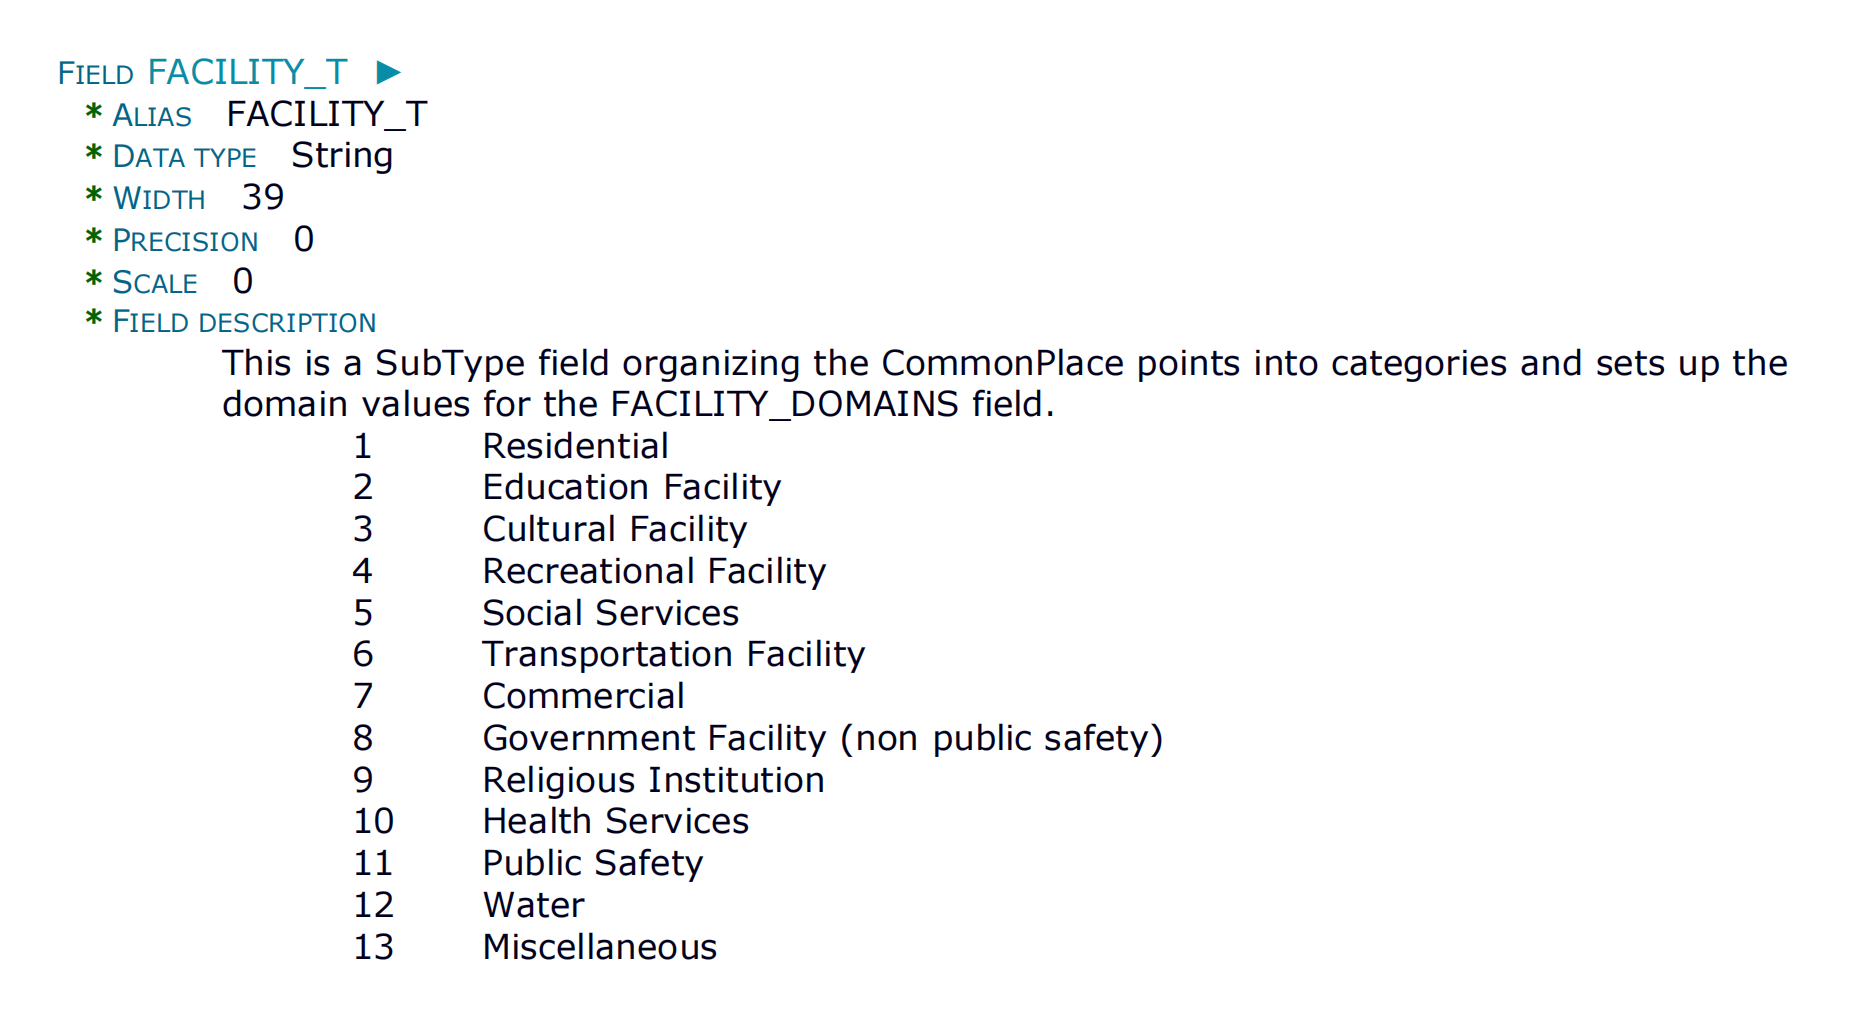

In [58]:
poi = pd.read_csv('data/Points_of_Interest.csv')
poi.head()

,the_geom,SEGMENTID,COMPLEXID,SAFTYPE,SOS,PLACEID,FACI_DOM,BIN,BOROUGH,CREATED,MODIFIED,FACILITY_T,SOURCE,B7SC,PRI_ADD,NAME
0,POINT (-74.00701717096757 40.724634757833414),31895,0,N,1.0,567,9,0,1.0,05/14/2009 12:00:00 AM,11/18/2011 12:00:00 AM,6,DoITT,19743001.0,0,HOLLAND
1,POINT (-73.82661642130311 40.797182526598505),306303,3378,N,2.0,568,8,0,4.0,05/14/2009 12:00:00 AM,01/09/2017 12:00:00 AM,6,DoITT,49731001.0,0,WHITESTONE
2,POINT (-73.99395441100663 40.70384707235758),144842,3960,N,2.0,576,8,0,3.0,05/14/2009 12:00:00 AM,01/22/2018 12:00:00 AM,6,DoITT,39734001.0,0,BROOKLYN
3,POINT (-73.9919414213091 40.70960010711745),162664,0,N,1.0,580,8,0,1.0,05/14/2009 12:00:00 AM,05/11/2011 12:00:00 AM,6,DoITT,19795001.0,0,MANHATTAN
4,POINT (-73.9526609766105 40.73906602249743),157362,0,N,1.0,582,8,0,3.0,05/14/2009 12:00:00 AM,03/03/2017 12:00:00 AM,6,DoITT,39740001.0,0,PULASKI


In [59]:
poi.columns

Index(['the_geom', 'SEGMENTID', 'COMPLEXID', 'SAFTYPE', 'SOS', 'PLACEID',
       'FACI_DOM', 'BIN', 'BOROUGH', 'CREATED', 'MODIFIED', 'FACILITY_T',
       'SOURCE', 'B7SC', 'PRI_ADD', 'NAME'],
      dtype='object')

In [60]:
poi_filtered = poi[['the_geom', 'PLACEID','FACILITY_T','NAME']]
poi_filtered.head()

,the_geom,PLACEID,FACILITY_T,NAME
0,POINT (-74.00701717096757 40.724634757833414),567,6,HOLLAND
1,POINT (-73.82661642130311 40.797182526598505),568,6,WHITESTONE
2,POINT (-73.99395441100663 40.70384707235758),576,6,BROOKLYN
3,POINT (-73.9919414213091 40.70960010711745),580,6,MANHATTAN
4,POINT (-73.9526609766105 40.73906602249743),582,6,PULASKI


In [61]:
poi_types = {
    1: "Residential",
    2: "Education Facility",
    3: "Cultural Facility",
    4: "Recreational Facility",
    5: "Social Services",
    6: "Transportation Facility",
    7: "Commercial",
    8: "Government Facility",
    9: "Religious Institution",
    10: "Health Services",
    11: "Public Safety"
}

poi_filtered = poi_filtered[~poi_filtered['FACILITY_T'].isin([12, 13])]
# Map FACILITY_T to text labels
poi_filtered['category'] = poi_filtered['FACILITY_T'].map(poi_types)

poi_filtered.head()

,the_geom,PLACEID,FACILITY_T,NAME,category
0,POINT (-74.00701717096757 40.724634757833414),567,6,HOLLAND,Transportation Facility
1,POINT (-73.82661642130311 40.797182526598505),568,6,WHITESTONE,Transportation Facility
2,POINT (-73.99395441100663 40.70384707235758),576,6,BROOKLYN,Transportation Facility
3,POINT (-73.9919414213091 40.70960010711745),580,6,MANHATTAN,Transportation Facility
4,POINT (-73.9526609766105 40.73906602249743),582,6,PULASKI,Transportation Facility


In [62]:
from shapely import wkt

# Convert the_geom from WKT strings to Shapely geometry objects
poi_filtered['geometry'] = poi_filtered['the_geom'].apply(wkt.loads)

# Now create the GeoDataFrame
poi_gdf = gpd.GeoDataFrame(
    poi_filtered,
    geometry='geometry',
    crs="EPSG:4326"
)

# Then convert CRS
poi_gdf = poi_gdf.to_crs("EPSG:2263")
poi_gdf = poi_gdf.drop(columns=['the_geom'])

poi_gdf.head()

,PLACEID,FACILITY_T,NAME,category,geometry
0,567,6,HOLLAND,Transportation Facility,POINT (982304.992 203280.606)
1,568,6,WHITESTONE,Transportation Facility,POINT (1032255.829 229759.571)
2,576,6,BROOKLYN,Transportation Facility,POINT (985926.229 195707)
3,580,6,MANHATTAN,Transportation Facility,POINT (986484.168 197803.048)
4,582,6,PULASKI,Transportation Facility,POINT (997368.511 208541.834)


### Street

In [63]:
street_data = gpd.read_file('data/dcp_dcm_street_centerline')
street_data.head()

,cartodb_id,borough,feat_type,feat_statu,street_nm,honorarynm,old_st_nm,streetwidt,route_type,roadwaytyp,build_stat,record_st,paper_st,stair_st,cco_st,marg_wharf,edit_date,shape_leng,geometry
0,4940,Manhattan,Mapped_St,City_St,East 119 Street,None,None,60,Gen_use,Surface_ST,Improved,None,None,None,None,None,NaT,510.013303,"LINESTRING (-73.94505 40.8026, -73.94344 40.80..."
1,6501,Queens,Mapped_St,City_St,Skillman Avenue,None,None,80,Gen_use,Surface_ST,Improved,None,N,None,None,No,NaT,613.980324,"MULTILINESTRING ((-73.93326 40.74628, -73.9322..."
2,8054,Queens,Mapped_St,City_St,63 Drive,None,None,80,Gen_use,Surface_ST,Improved,None,N,None,None,No,NaT,674.703827,"LINESTRING (-73.84769 40.73428, -73.84543 40.7..."
3,12182,Staten Island,Mapped_St,City_St,Jackson Avenue,None,None,50,Gen_use,Surface_ST,Improved,None,None,None,None,None,NaT,491.057026,"LINESTRING (-74.0674 40.59773, -74.06661 40.59..."
4,56,Brooklyn,Mapped_St,City_St,Ludlam Place,None,None,60,Gen_use,Surface_ST,Improved,None,None,None,None,None,NaT,430.844270,"LINESTRING (-73.95508 40.66444, -73.95497 40.6..."


In [64]:
print(street_data.crs)

EPSG:4326


In [65]:
# Project the street data to a metric CRS (EPSG:2263)
street_data_projected = street_data.to_crs("EPSG:2263")

# Calculate the length of each street segment (in meters)
street_data_projected['length_meters'] = street_data_projected.geometry.length

# Map the calculated lengths back to the original street_data (with original CRS)
street_data['length_meters'] = street_data_projected['length_meters']

street_data.head()

,cartodb_id,borough,feat_type,feat_statu,street_nm,honorarynm,old_st_nm,streetwidt,route_type,roadwaytyp,build_stat,record_st,paper_st,stair_st,cco_st,marg_wharf,edit_date,shape_leng,geometry,length_meters
0,4940,Manhattan,Mapped_St,City_St,East 119 Street,None,None,60,Gen_use,Surface_ST,Improved,None,None,None,None,None,NaT,510.013303,"LINESTRING (-73.94505 40.8026, -73.94344 40.80...",510.013303
1,6501,Queens,Mapped_St,City_St,Skillman Avenue,None,None,80,Gen_use,Surface_ST,Improved,None,N,None,None,No,NaT,613.980324,"MULTILINESTRING ((-73.93326 40.74628, -73.9322...",613.980324
2,8054,Queens,Mapped_St,City_St,63 Drive,None,None,80,Gen_use,Surface_ST,Improved,None,N,None,None,No,NaT,674.703827,"LINESTRING (-73.84769 40.73428, -73.84543 40.7...",674.703827
3,12182,Staten Island,Mapped_St,City_St,Jackson Avenue,None,None,50,Gen_use,Surface_ST,Improved,None,None,None,None,None,NaT,491.057026,"LINESTRING (-74.0674 40.59773, -74.06661 40.59...",491.057026
4,56,Brooklyn,Mapped_St,City_St,Ludlam Place,None,None,60,Gen_use,Surface_ST,Improved,None,None,None,None,None,NaT,430.844270,"LINESTRING (-73.95508 40.66444, -73.95497 40.6...",430.844270


In [66]:
street_data = street_data[['cartodb_id', 'street_nm', 'route_type', 'geometry', 'length_meters']]
street_data.head()

,cartodb_id,street_nm,route_type,geometry,length_meters
0,4940,East 119 Street,Gen_use,"LINESTRING (-73.94505 40.8026, -73.94344 40.80...",510.013303
1,6501,Skillman Avenue,Gen_use,"MULTILINESTRING ((-73.93326 40.74628, -73.9322...",613.980324
2,8054,63 Drive,Gen_use,"LINESTRING (-73.84769 40.73428, -73.84543 40.7...",674.703827
3,12182,Jackson Avenue,Gen_use,"LINESTRING (-74.0674 40.59773, -74.06661 40.59...",491.057026
4,56,Ludlam Place,Gen_use,"LINESTRING (-73.95508 40.66444, -73.95497 40.6...",430.844270


In [67]:
street_gdf = gpd.GeoDataFrame(
    street_data,
    geometry='geometry',
    crs="EPSG:4326"
)
street_gdf = street_gdf.to_crs("EPSG:2263")
street_gdf.head()

,cartodb_id,street_nm,route_type,geometry,length_meters
0,4940,East 119 Street,Gen_use,"LINESTRING (999462.778 231690.097, 999909.173 ...",510.013303
1,6501,Skillman Avenue,Gen_use,"MULTILINESTRING ((1002742.547 211174.97, 10030...",613.980324
2,8054,63 Drive,Gen_use,"LINESTRING (1026459.668 206830.298, 1027087.88...",674.703827
3,12182,Jackson Avenue,Gen_use,"LINESTRING (965533.463 157054.218, 965750.592 ...",491.057026
4,56,Ludlam Place,Gen_use,"LINESTRING (996711.068 181351.643, 996742.242 ...",430.844270


### Income & Census

#### income

In [68]:
income = pd.read_csv('data/income_processedcsv.csv')
income.head()

,GEOID,NAME,Median_income,revise
0,36005000100,Census Tract 1; Bronx County; New York,-,5000.0
1,36005000200,Census Tract 2; Bronx County; New York,115064,NaN
2,36005000400,Census Tract 4; Bronx County; New York,100553,NaN
3,36005001600,Census Tract 16; Bronx County; New York,41362,NaN
4,36005001901,Census Tract 19.01; Bronx County; New York,49500,NaN


In [69]:
income.loc[income['Median_income'] == '-', 'Median_income'] = income['revise']

In [70]:
income = income.drop(columns=['revise'])
income['Median_income'] = income['Median_income'].astype(int)

In [71]:
census_tracts= gpd.read_file('data/2020CensusData/nyct2020_25a')
census_tracts.head()

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,I,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((972081.788 190733.467, 972184...."
1,14.01,1,Manhattan,001401,1001401,I,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,4103,5075.332000,1.006117e+06,"POLYGON ((987475.016 200297.218, 987705.443 20..."
2,14.02,1,Manhattan,001402,1001402,E,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4103,4459.156019,1.226206e+06,"POLYGON ((988387.669 201258.312, 988621.002 20..."
3,18,1,Manhattan,001800,1001800,I,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001800,4103,6391.921174,2.399277e+06,"POLYGON ((987062.275 201781.687, 987099.571 20..."
4,22.01,1,Manhattan,002201,1002201,E,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061002201,4103,5779.062608,1.740174e+06,"POLYGON ((990139.804 201568.505, 990129.867 20..."


In [72]:
census_tracts = census_tracts[['GEOID', 'geometry']]
census_tracts.head()

,GEOID,geometry
0,36061000100,"MULTIPOLYGON (((972081.788 190733.467, 972184...."
1,36061001401,"POLYGON ((987475.016 200297.218, 987705.443 20..."
2,36061001402,"POLYGON ((988387.669 201258.312, 988621.002 20..."
3,36061001800,"POLYGON ((987062.275 201781.687, 987099.571 20..."
4,36061002201,"POLYGON ((990139.804 201568.505, 990129.867 20..."


In [73]:
# Merge with income data
census_tracts['GEOID'] = census_tracts['GEOID'].astype(str)
income['GEOID'] = income['GEOID'].astype(str)

income_gdf = pd.merge(
    income,
    census_tracts,
    on='GEOID',
    how='right'
)

income_gdf.head()

,GEOID,NAME,Median_income,geometry
0,36061000100,Census Tract 1; New York County; New York,5000.0,"MULTIPOLYGON (((972081.788 190733.467, 972184...."
1,36061001401,Census Tract 14.01; New York County; New York,89873.0,"POLYGON ((987475.016 200297.218, 987705.443 20..."
2,36061001402,Census Tract 14.02; New York County; New York,46615.0,"POLYGON ((988387.669 201258.312, 988621.002 20..."
3,36061001800,Census Tract 18; New York County; New York,74485.0,"POLYGON ((987062.275 201781.687, 987099.571 20..."
4,36061002201,Census Tract 22.01; New York County; New York,35700.0,"POLYGON ((990139.804 201568.505, 990129.867 20..."


#### census

In [74]:
census = pd.read_csv('data/2020CensusData/nyc-decennialcensusdata_2020_census-blocks.csv')
census.head()

/var/folders/78/73hgkmn13jjcw_dhfbc0tf4h0000gn/T/ipykernel_37140/2751652994.py:1: DtypeWarning: Columns (10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,52,54,62,66,68,70,72,74,76,82,84,86,88,90,92,94,96,98,100,102,104,106,108,110,112,114,116,118,120,122,126,128,130,132,134,136,138,140,142,144,146,148,150,152,154,156,158,160,162,164,166,168,170,172,174,176,180,186,188,190,192,194,196,198,200,202,206,208,210,212,214,216,218,220,222,224,226,228,230) have mixed types. Specify dtype option on import or set low_memory=False.
  census = pd.read_csv('data/2020CensusData/nyc-decennialcensusdata_2020_census-blocks.csv')


,Year,GeogType,FIPSCode,BoroCode,GeogName,GeoID,Unnamed: 6,Unnamed: 7,Pop1,Pop1P,...,ROcHH2,ROcHH2P,ROcHH3,ROcHH3P,ROcHH4,ROcHH4P,ROcHH5pl,ROcHH5plP,LandAcres,LandAcresP
0,2020,NYC2020,3651000,0,New York City,0,NaN,NaN,"8,804,190",100.0,...,"670,144",28.3,"374,447",15.8,"263,906",11.2,"254,065",10.7,"192,289",NaN
1,2020,Boro2020,5,2,Bronx,2,NaN,NaN,"1,472,654",100.0,...,"102,118",24.0,"77,071",18.1,"58,043",13.7,"61,014",14.4,"26,990",NaN
2,2020,Boro2020,47,3,Brooklyn,3,NaN,NaN,"2,736,074",100.0,...,"215,925",29.1,"122,906",16.6,"84,476",11.4,"89,012",12.0,"44,401",NaN
3,2020,Boro2020,61,1,Manhattan,1,NaN,NaN,"1,694,251",100.0,...,"196,690",31.4,"75,343",12.0,"43,007",6.9,"27,660",4.4,"14,500",NaN
4,2020,Boro2020,81,4,Queens,4,NaN,NaN,"2,405,464",100.0,...,"139,627",27.6,"89,400",17.6,"70,538",13.9,"68,090",13.4,"69,583",NaN


In [75]:
print(census.columns.tolist())

['Year', 'GeogType', 'FIPSCode', 'BoroCode', 'GeogName', 'GeoID', 'Unnamed: 6', 'Unnamed: 7', 'Pop1', 'Pop1P', 'Male ', 'Male P', 'Fem', 'FemP', 'PopU5', 'PopU5P', 'Pop5t9', 'Pop5t9P', 'Pop10t14', 'Pop10t14P', 'Pop15t19', 'Pop15t19P', 'Pop20t24', 'Pop20t24P', 'Pop25t29', 'Pop25t29P', 'Pop30t34', 'Pop30t34P', 'Pop35t39', 'Pop35t39P', 'Pop40t44', 'Pop40t44P', 'Pop45t49', 'Pop45t49P', 'Pop50t54', 'Pop50t54P', 'Pop55t59', 'Pop55t59P', 'Pop60t64', 'Pop60t64P', 'Pop65t69', 'Pop65t69P', 'Pop70t74', 'Pop70t74P', 'Pop75t79', 'Pop75t79P', 'Pop80t84', 'Pop80t84P', 'Pop85pl', 'Pop85plP', 'MdAge', 'MdAgeP', 'PopU18', 'PopU18P', 'Pop65pl', 'Pop65plP', 'AgDpdRt', 'AgDpdRtP', 'OdAgDpdRt', 'OdAgDpdRtP', 'ChldDpdRt', 'ChldDpdRtP', 'PopAcre', 'PopAcreP', 'Pop2', 'Pop2P', 'Hsp1', 'Hsp1P', 'WNH', 'WNHP', 'BNH', 'BNHP', 'ANH', 'ANHP', 'ONH', 'ONHP', 'TwoPlNH', 'TwoPlNHP', 'Pop3', 'Pop3P', 'PopInHH_1', 'PopInHH_1P', 'HHldr', 'HHldrP', 'Spouse', 'SpouseP', 'OpSxS', 'OpSxSP', 'SmSxS', 'SmSxSP', 'UMrdPtnr', 'UM

In [76]:
census = census[['GeogType', 'FIPSCode', 'BoroCode', 'GeogName', 'GeoID',
                 'Pop1','Pop15t19', 'Pop20t24', 'Pop25t29']]
census = census[census['GeogType'] == 'CB2020']

cols_to_clean = ['Pop1', 'Pop15t19', 'Pop20t24', 'Pop25t29']
for col in cols_to_clean:
    census[col] = census[col].replace(',', '', regex=True).astype(float)
    
census.head()

,GeogType,FIPSCode,BoroCode,GeogName,GeoID,Pop1,Pop15t19,Pop20t24,Pop25t29
6,CB2020,5,2,Bronx,20001000001,0.0,0.0,0.0,0.0
7,CB2020,5,2,Bronx,20001000002,0.0,0.0,0.0,0.0
8,CB2020,5,2,Bronx,20001001000,171.0,0.0,34.0,28.0
9,CB2020,5,2,Bronx,20001001001,1344.0,41.0,98.0,266.0
10,CB2020,5,2,Bronx,20001001002,367.0,96.0,128.0,36.0


In [77]:
census['GeoID'] = census['GeoID'].astype(str)
census['GeoID_CT'] = census['GeoID'].str[:7]
ct_data = census.groupby('GeoID_CT').agg(
    Pop1=('Pop1', 'sum'),
    Pop15t19=('Pop15t19', 'sum'),
    Pop20t24=('Pop20t24', 'sum'),
    Pop25t29=('Pop25t29', 'sum')
).reset_index()
ct_data.head()

,GeoID_CT,Pop1,Pop15t19,Pop20t24,Pop25t29
0,1000100,0.0,0.0,0.0,0.0
1,1000201,2012.0,126.0,167.0,204.0
2,1000202,7266.0,372.0,373.0,357.0
3,1000500,5.0,0.0,1.0,0.0
4,1000600,11616.0,550.0,807.0,1031.0


In [78]:
boro_to_county = {
    '1': '061', # Manhattan
    '2': '005', # Bronx
    '3': '047', # Brooklyn
    '4': '081', # Queens
    '5': '085'  # Staten Island
}

ct_data['BoroCode'] = ct_data['GeoID_CT'].astype(str).str[0]
ct_data['CountyCode'] = ct_data['BoroCode'].map(boro_to_county)
ct_data['TractCode'] = ct_data['GeoID_CT'].astype(str).str[1:7]

ct_data['GEOID'] = '36' + ct_data['CountyCode'] + ct_data['TractCode']

In [79]:
ct_data = ct_data[['GEOID', 'Pop1', 'Pop15t19', 'Pop20t24', 'Pop25t29']]
ct_data['GEOID'] = ct_data['GEOID'].astype(str)
ct_data.head()

,GEOID,Pop1,Pop15t19,Pop20t24,Pop25t29
0,36061000100,0.0,0.0,0.0,0.0
1,36061000201,2012.0,126.0,167.0,204.0
2,36061000202,7266.0,372.0,373.0,357.0
3,36061000500,5.0,0.0,1.0,0.0
4,36061000600,11616.0,550.0,807.0,1031.0


In [80]:
ct_data['Pop15t29'] = ct_data['Pop15t19'] + ct_data['Pop20t24'] + ct_data['Pop25t29']
ct_data = ct_data.rename(columns={'Pop1': 'Total_Population'})

socio_eco_gdf = pd.merge(
    ct_data,
    income_gdf,
    on='GEOID',
    how='right'
)

socio_eco_gdf.head()

,GEOID,Total_Population,Pop15t19,Pop20t24,Pop25t29,Pop15t29,NAME,Median_income,geometry
0,36061000100,0.0,0.0,0.0,0.0,0.0,Census Tract 1; New York County; New York,5000.0,"MULTIPOLYGON (((972081.788 190733.467, 972184...."
1,36061001401,3543.0,145.0,116.0,147.0,408.0,Census Tract 14.01; New York County; New York,89873.0,"POLYGON ((987475.016 200297.218, 987705.443 20..."
2,36061001402,3418.0,93.0,341.0,529.0,963.0,Census Tract 14.02; New York County; New York,46615.0,"POLYGON ((988387.669 201258.312, 988621.002 20..."
3,36061001800,7934.0,318.0,1132.0,1252.0,2702.0,Census Tract 18; New York County; New York,74485.0,"POLYGON ((987062.275 201781.687, 987099.571 20..."
4,36061002201,6969.0,296.0,684.0,817.0,1797.0,Census Tract 22.01; New York County; New York,35700.0,"POLYGON ((990139.804 201568.505, 990129.867 20..."


In [81]:
print(census_tracts.crs)

EPSG:2263


In [82]:
socio_eco_gdf = gpd.GeoDataFrame(
    socio_eco_gdf,
    geometry = 'geometry',
    crs="EPSG:2263"
)

socio_eco_gdf['area_sqkm'] = socio_eco_gdf.geometry.area / 1000000  # 转换为平方公里
socio_eco_gdf['population_density'] = socio_eco_gdf['Total_Population'] / socio_eco_gdf['area_sqkm']

socio_eco_gdf['youth_population_pct'] = (socio_eco_gdf['Pop15t29'] / socio_eco_gdf['Total_Population']) * 100
socio_eco_gdf['youth_population_pct'] = socio_eco_gdf['youth_population_pct'].fillna(0)

socio_eco_gdf.head()

,GEOID,Total_Population,Pop15t19,Pop20t24,Pop25t29,Pop15t29,NAME,Median_income,geometry,area_sqkm,population_density,youth_population_pct
0,36061000100,0.0,0.0,0.0,0.0,0.0,Census Tract 1; New York County; New York,5000.0,"MULTIPOLYGON (((972081.788 190733.467, 972184....",1.842974,0.000000,0.000000
1,36061001401,3543.0,145.0,116.0,147.0,408.0,Census Tract 14.01; New York County; New York,89873.0,"POLYGON ((987475.016 200297.218, 987705.443 20...",1.006117,3521.460689,11.515665
2,36061001402,3418.0,93.0,341.0,529.0,963.0,Census Tract 14.02; New York County; New York,46615.0,"POLYGON ((988387.669 201258.312, 988621.002 20...",1.226206,2787.459294,28.174371
3,36061001800,7934.0,318.0,1132.0,1252.0,2702.0,Census Tract 18; New York County; New York,74485.0,"POLYGON ((987062.275 201781.687, 987099.571 20...",2.399277,3306.829703,34.055962
4,36061002201,6969.0,296.0,684.0,817.0,1797.0,Census Tract 22.01; New York County; New York,35700.0,"POLYGON ((990139.804 201568.505, 990129.867 20...",1.740174,4004.772013,25.785622


In [83]:
socio_eco_gdf.to_csv('processed_data/socio_eco_gdf.csv', index= False)

In [84]:
socio_eco_gdf.shape

(2325, 12)

# EDA


### Read all data files

In [107]:
crime_gdf.head()

,CMPLNT_NUM,datetime,OFNS_DESC,crime_category,BORO_NM,Latitude,Longitude,year,month,day,hour,dayofweek,is_weekend,geometry
0,242132877,2022-02-07 14:30:00,RAPE,violent,BRONX,40.837842,-73.919628,2022,2,7,14,0,0,POINT (1006489.602 244536.018)
1,242306354,2022-03-14 17:50:00,BURGLARY,property,BRONX,40.822622,-73.930942,2022,3,14,17,0,0,POINT (1003363.237 238988.1)
2,247060032,2022-06-23 10:10:00,ROBBERY,property,BROOKLYN,40.577312,-73.962821,2022,6,23,10,3,0,POINT (994577.995 149608.961)
3,248149060,2022-07-17 20:11:00,FELONY ASSAULT,violent,BROOKLYN,40.662554,-73.908920,2022,7,17,20,6,1,POINT (1009519.001 180675.998)
4,262255016,2023-01-20 02:00:00,RAPE,violent,BRONX,40.822912,-73.870041,2023,1,20,2,4,0,POINT (1020218.605 239113.017)


In [108]:
crime_gdf['OFNS_DESC'].unique()

array(['RAPE', 'BURGLARY', 'ROBBERY', 'FELONY ASSAULT', 'PETIT LARCENY',
       'GRAND LARCENY', 'MURDER & NON-NEGL. MANSLAUGHTER',
       'GRAND LARCENY OF MOTOR VEHICLE', 'PETIT LARCENY OF MOTOR VEHICLE',
       'ARSON'], dtype=object)

In [109]:
subway_gdf.head()

,Station ID,Complex ID,Stop Name,Borough,CBD,Daytime Routes,Structure,Latitude,Longitude,route_count,entrance_count,stations_in_complex,year,ridership,geometry,buffer_800m,is_transfer
0,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,2,5,1,2022,3030256.0,POINT (1008613.828 221655.558),"POLYGON ((1009413.828 221655.558, 1009409.976 ...",True
1,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,2,5,1,2023,3287685.0,POINT (1008613.828 221655.558),"POLYGON ((1009413.828 221655.558, 1009409.976 ...",True
2,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,2,5,1,2024,3394788.0,POINT (1008613.828 221655.558),"POLYGON ((1009413.828 221655.558, 1009409.976 ...",True
3,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,2,6,1,2022,2189977.0,POINT (1007006.55 219913.211),"POLYGON ((1007806.55 219913.211, 1007802.698 2...",True
4,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,2,6,1,2023,2360702.0,POINT (1007006.55 219913.211),"POLYGON ((1007806.55 219913.211, 1007802.698 2...",True


In [110]:
poi_gdf.head()

,PLACEID,FACILITY_T,NAME,category,geometry
0,567,6,HOLLAND,Transportation Facility,POINT (982304.992 203280.606)
1,568,6,WHITESTONE,Transportation Facility,POINT (1032255.829 229759.571)
2,576,6,BROOKLYN,Transportation Facility,POINT (985926.229 195707)
3,580,6,MANHATTAN,Transportation Facility,POINT (986484.168 197803.048)
4,582,6,PULASKI,Transportation Facility,POINT (997368.511 208541.834)


In [111]:
street_gdf.head()

,cartodb_id,street_nm,route_type,geometry,length_meters
0,4940,East 119 Street,Gen_use,"LINESTRING (999462.778 231690.097, 999909.173 ...",510.013303
1,6501,Skillman Avenue,Gen_use,"MULTILINESTRING ((1002742.547 211174.97, 10030...",613.980324
2,8054,63 Drive,Gen_use,"LINESTRING (1026459.668 206830.298, 1027087.88...",674.703827
3,12182,Jackson Avenue,Gen_use,"LINESTRING (965533.463 157054.218, 965750.592 ...",491.057026
4,56,Ludlam Place,Gen_use,"LINESTRING (996711.068 181351.643, 996742.242 ...",430.844270


In [112]:
socio_eco_gdf.head()

,GEOID,Total_Population,Pop15t19,Pop20t24,Pop25t29,Pop15t29,NAME,Median_income,geometry,area_sqkm,population_density,youth_population_pct
0,36061000100,0.0,0.0,0.0,0.0,0.0,Census Tract 1; New York County; New York,5000.0,"MULTIPOLYGON (((972081.788 190733.467, 972184....",1.842974,0.000000,0.000000
1,36061001401,3543.0,145.0,116.0,147.0,408.0,Census Tract 14.01; New York County; New York,89873.0,"POLYGON ((987475.016 200297.218, 987705.443 20...",1.006117,3521.460689,11.515665
2,36061001402,3418.0,93.0,341.0,529.0,963.0,Census Tract 14.02; New York County; New York,46615.0,"POLYGON ((988387.669 201258.312, 988621.002 20...",1.226206,2787.459294,28.174371
3,36061001800,7934.0,318.0,1132.0,1252.0,2702.0,Census Tract 18; New York County; New York,74485.0,"POLYGON ((987062.275 201781.687, 987099.571 20...",2.399277,3306.829703,34.055962
4,36061002201,6969.0,296.0,684.0,817.0,1797.0,Census Tract 22.01; New York County; New York,35700.0,"POLYGON ((990139.804 201568.505, 990129.867 20...",1.740174,4004.772013,25.785622


In [113]:
from shapely.geometry import box
import osmnx as ox
import networkx as nx
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import shap

### Integrate data to Census Tracts level

(Socio-economic data has been pre-processed)

In [114]:
# Use the existing socio_eco_gdf as the base DataFrame
ct_data = socio_eco_gdf.copy()

# Calculate area (in square kilometers)
ct_data['area_sqkm'] = ct_data.geometry.area / 1_000_000

In [115]:
# Fix all geometries before performing any spatial operations
import shapely

# Fix CT (Census Tract) geometries
print("Fixing CT geometries...")
invalid_geoms = 0
for idx, row in ct_data.iterrows():
    if not row.geometry.is_valid:
        try:
            # Attempt to fix invalid geometry using buffer(0)
            fixed_geom = row.geometry.buffer(0)
            if fixed_geom.is_valid:
                ct_data.loc[idx, 'geometry'] = fixed_geom
                invalid_geoms += 1
            else:
                # If buffer(0) doesn't work, try a more complex fix
                fixed_geom = shapely.make_valid(row.geometry)
                ct_data.loc[idx, 'geometry'] = fixed_geom
                invalid_geoms += 1
        except Exception as e:
            print(f"Failed to fix geometry for CT {idx}: {e}")

print(f"Fixed {invalid_geoms} invalid CT geometries")

# Similarly fix geometries in street_gdf
print("Fixing street geometries...")
invalid_roads = 0
valid_streets = []
for idx, row in street_gdf.iterrows():
    if not row.geometry.is_valid:
        try:
            fixed_geom = row.geometry.buffer(0)
            if fixed_geom.is_valid:
                street_gdf.loc[idx, 'geometry'] = fixed_geom
                valid_streets.append(idx)
                invalid_roads += 1
            else:
                fixed_geom = shapely.make_valid(row.geometry)
                street_gdf.loc[idx, 'geometry'] = fixed_geom
                valid_streets.append(idx)
                invalid_roads += 1
        except Exception as e:
            print(f"Failed to fix geometry for street {idx}: {e}")
    else:
        valid_streets.append(idx)

# Keep only valid street geometries
street_gdf = street_gdf.loc[valid_streets]
print(f"Fixed {invalid_roads} invalid street geometries")


Fixing CT geometries...
Fixed 0 invalid CT geometries
Fixing street geometries...
Fixed 0 invalid street geometries


#### Subway features

In [116]:
# Calculate subway station features
print("Calculating subway station features...")

# Initialize new columns in CT data
ct_data['station_count'] = 0
ct_data['station_density'] = 0
ct_data['avg_ridership'] = 0
ct_data['transfer_station_ratio'] = 0 
ct_data['avg_entrances'] = 0           
ct_data['station_coverage'] = 0

ct_data['station_count'] = ct_data['station_count'].astype(float)
ct_data['station_coverage'] = ct_data['station_coverage'].astype(float)
ct_data['station_density'] = ct_data['station_density'].astype(float)
ct_data['transfer_station_ratio'] = ct_data['transfer_station_ratio'].astype(float)
ct_data['avg_ridership'] = ct_data['avg_ridership'].astype(float)
ct_data['avg_entrances'] = ct_data['avg_entrances'].astype(float)

# Create 800-meter buffer around subway stations
subway_gdf['buffer_800m'] = subway_gdf.geometry.buffer(800)

# Define transfer stations: stations with more than one route
subway_gdf['is_transfer'] = subway_gdf['route_count'] > 1

# Spatial join: associate subway stations with CTs
metro_ct_join = gpd.sjoin(subway_gdf, ct_data, how='left', predicate='within')

# Count the number of subway stations per CT
station_counts = metro_ct_join.groupby('index_right').size()

# Iterate through each CT
for idx, ct in ct_data.iterrows():
    ct_id = ct.name
    
    # If this CT contains subway stations
    if ct_id in station_counts.index:
        # Count and density of stations
        station_count = station_counts[ct_id]
        ct_data.at[idx, 'station_count'] = station_count
        ct_data.at[idx, 'station_density'] = station_count / ct_data.at[idx, 'area_sqkm']
        
        # Get all subway stations within this CT
        ct_stations = metro_ct_join[metro_ct_join['index_right'] == ct_id]
        
        # Calculate ratio of transfer stations
        transfer_count = ct_stations['is_transfer'].sum()
        ct_data.at[idx, 'transfer_station_ratio'] = transfer_count / station_count if station_count > 0 else 0
        
        # Calculate average ridership 
        if 'ridership' in ct_stations.columns:
            # Group by year and take the average for the latest year
            latest_year = ct_stations['year'].max()
            latest_stations = ct_stations[ct_stations['year'] == latest_year]
            ct_data.at[idx, 'avg_ridership'] = latest_stations['ridership'].mean()
        
        # Calculate average number of entrances 
        if 'entrance_count' in ct_stations.columns:
            ct_data.at[idx, 'avg_entrances'] = ct_stations['entrance_count'].mean()
    
    # Calculate station coverage ratio (percentage of CT area within 800m of any station)
    try:
        ct_geometry = ct.geometry
        if not ct_geometry.is_valid:
            ct_geometry = ct_geometry.buffer(0)  # Attempt to fix invalid geometry
            
        coverage_area = gpd.GeoSeries([geom for geom in subway_gdf['buffer_800m']])
        union_buffer = coverage_area.union_all()
        intersection = ct_geometry.intersection(union_buffer).area
        coverage_ratio = intersection / ct_geometry.area
        ct_data.at[idx, 'station_coverage'] = coverage_ratio
    except Exception as e:
        print(f"Error calculating station coverage (CT {idx}): {e}")
        ct_data.at[idx, 'station_coverage'] = 0


Calculating subway station features...


#### Crime rate

In [117]:
# Calculate crime rate standardized by population
print("Calculating population-standardized crime rate...")


Calculating population-standardized crime rate...


In [118]:
(ct_data['Total_Population'] <= 0).sum()

33

In [119]:
# Initialize crime rate columns (per 1,000 people)
ct_data['annual_total_crime_rate'] = 0
ct_data['annual_property_crime_rate'] = 0
ct_data['annual_violent_crime_rate'] = 0

ct_data['annual_total_crime_rate'] = ct_data['annual_total_crime_rate'].astype(float)
ct_data['annual_property_crime_rate'] = ct_data['annual_property_crime_rate'].astype(float)
ct_data['annual_violent_crime_rate'] = ct_data['annual_violent_crime_rate'].astype(float)

# Ensure all geometries in crime_gdf are valid
crime_gdf = crime_gdf[crime_gdf.geometry.is_valid]

# Spatial join: link crime incidents to census tracts (CTs)
crime_ct_join = gpd.sjoin(crime_gdf, ct_data, how='left', predicate='within')

# Determine the number of years covered in the crime dataset
years_in_data = crime_gdf['year'].nunique() if 'year' in crime_gdf.columns else 3
print(f"Crime data spans {years_in_data} years")

# Group crime counts by CT and crime category
crime_counts = crime_ct_join.groupby(['index_right', 'crime_category']).size().reset_index(name='count')

# Calculate annual crime rates per CT
for idx, ct in ct_data.iterrows():
    ct_id = ct.name
    
    # Get population for the CT
    population = ct_data.at[idx, 'Total_Population']
    
    # Handle zero or negative population
    if population <= 0:
        print(f"Warning: CT {idx} has zero or negative population")
        ct_data.at[idx, 'annual_total_crime_rate'] = np.nan
        ct_data.at[idx, 'annual_property_crime_rate'] = np.nan
        ct_data.at[idx, 'annual_violent_crime_rate'] = np.nan
        continue
    
    # Filter crimes within this CT
    ct_crimes = crime_counts[crime_counts['index_right'] == ct_id]
    
    # Calculate total crime rate (annual average per 1,000 people)
    total_crimes = ct_crimes['count'].sum() if not ct_crimes.empty else 0
    ct_data.at[idx, 'annual_total_crime_rate'] = (total_crimes / years_in_data) / population * 1000
    
    # Calculate category-specific crime rates (annual average per 1,000 people)
    for category in ['property', 'violent']:
        category_crimes = ct_crimes[ct_crimes['crime_category'] == category]
        crime_count = category_crimes['count'].sum() if not category_crimes.empty else 0
        ct_data.at[idx, f'annual_{category}_crime_rate'] = (crime_count / years_in_data) / population * 1000


Crime data spans 3 years


#### POI and Street Features

In [120]:
# 1. Compute POI Density Features by Category
print("Computing POI density features by category...")

# Ensure valid geometry
poi_gdf = poi_gdf[poi_gdf.geometry.is_valid]

# Spatial join: link POI points to CT boundaries
poi_ct_join = gpd.sjoin(poi_gdf, ct_data, how='left', predicate='within')

# Retrieve all POI categories
poi_categories = poi_gdf['category'].unique()

# Create density columns for each POI category with initial value 0.0
for category in poi_categories:
    col_name = f'poi_density_{category}'
    ct_data[col_name] = 0.0  # Initialize with 0.0 (float) instead of NaN

# Compute POI density for each CT and each category
for idx, ct in ct_data.iterrows():
    ct_id = ct.name
    area = ct_data.at[idx, 'area_sqkm']
    
    # All POIs within this CT
    ct_pois = poi_ct_join[poi_ct_join['index_right'] == ct_id]
    
    # Compute density for each category
    if len(ct_pois) > 0 and 'category' in ct_pois.columns:
        category_counts = ct_pois['category'].value_counts()
        
        for category, count in category_counts.items():
            col_name = f'poi_density_{category}'
            if col_name in ct_data.columns:
                ct_data.at[idx, col_name] = count / area  

# 2. Compute Road Network Features
print("Computing road network features...")

# Initialize road density column with 0.0
ct_data['road_density'] = 0.0  # Initialize with 0.0 (float)

# Compute road density for each CT
for idx, ct in ct_data.iterrows():
    try:
        # Get and validate boundary geometry
        ct_boundary = ct.geometry
        if not ct_boundary.is_valid:
            ct_boundary = ct_boundary.buffer(0)  # Attempt to fix invalid geometry
        
        # Use conservative method to compute road density
        contained_roads = street_gdf[street_gdf.geometry.within(ct_boundary)]
        
        # Calculate total road length within boundary
        road_length = contained_roads.geometry.length.sum()
        
        # Convert to kilometers and compute density
        road_length_km = road_length / 1000
        ct_data.at[idx, 'road_density'] = road_length_km / ct_data.at[idx, 'area_sqkm']
    except Exception as e:
        print(f"Error computing road density for CT {idx}: {e}")
        # Value remains 0.0 from initialization

Computing POI density features by category...
Computing road network features...


#### Neighboring CT Crime Rate Feature

In [121]:
# Add Neighboring CT Crime Rate Feature (Normalized by Population)
print("Calculating neighboring CT crime rate normalized by population...")

# Initialize neighboring crime rate column
ct_data['neighboring_crime_rate'] = 0  # Population-normalized

# Find neighbors for each CT
neighbors_dict = {}
for idx, ct in ct_data.iterrows():
    try:
        ct_geom = ct.geometry
        if not ct_geom.is_valid:
            ct_geom = ct_geom.buffer(0)  # Fix invalid geometry
            
        # Use buffer to find neighbors—more robust than using touches
        buffer_distance = 1.0  # Distance unit should match your coordinate system
        buffered_geom = ct_geom.buffer(buffer_distance)
        touching = ct_data[ct_data.geometry.intersects(buffered_geom) & 
                            (ct_data.index != idx)]  # Exclude self
        
        neighbors_dict[idx] = touching.index.tolist()
    except Exception as e:
        print(f"Error finding neighbors for CT {idx}: {e}")
        neighbors_dict[idx] = []

# Calculate average crime rate of neighboring CTs
for idx, neighbors in neighbors_dict.items():
    if neighbors:
        try:
            # Calculate population-normalized neighboring crime rate
            ct_data.at[idx, 'neighboring_crime_rate'] = ct_data.loc[neighbors, 'annual_total_crime_rate'].mean()
        except Exception as e:
            print(f"Error calculating neighboring crime rate for CT {idx}: {e}")
            ct_data.at[idx, 'neighboring_crime_rate'] = 0

# Rename income column
ct_data = ct_data.rename(columns={'Median_income': 'income_level'})

# Save the integrated CT dataset
print("Saving integrated CT dataset...")

try:
    ct_data.to_csv('processed_data/ct_integrated_data_by_population.csv', index=False)
    print("Data integration completed!")
except Exception as e:
    print(f"Error saving dataset: {e}")


Calculating neighboring CT crime rate normalized by population...


/var/folders/78/73hgkmn13jjcw_dhfbc0tf4h0000gn/T/ipykernel_37140/3692268130.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '35.027741341638354' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ct_data.at[idx, 'neighboring_crime_rate'] = ct_data.loc[neighbors, 'annual_total_crime_rate'].mean()


Saving integrated CT dataset...
Data integration completed!


In [122]:
from scipy import stats
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [123]:
ct_data.columns

Index(['GEOID', 'Total_Population', 'Pop15t19', 'Pop20t24', 'Pop25t29',
       'Pop15t29', 'NAME', 'income_level', 'geometry', 'area_sqkm',
       'population_density', 'youth_population_pct', 'station_count',
       'station_density', 'avg_ridership', 'transfer_station_ratio',
       'avg_entrances', 'station_coverage', 'annual_total_crime_rate',
       'annual_property_crime_rate', 'annual_violent_crime_rate',
       'poi_density_Transportation Facility',
       'poi_density_Recreational Facility', 'poi_density_Education Facility',
       'poi_density_Residential', 'poi_density_Social Services',
       'poi_density_Religious Institution', 'poi_density_Cultural Facility',
       'poi_density_Public Safety', 'poi_density_Commercial',
       'poi_density_Government Facility', 'poi_density_Health Services',
       'road_density', 'neighboring_crime_rate'],
      dtype='object')

In [124]:
ct_data.head()

,GEOID,Total_Population,Pop15t19,Pop20t24,Pop25t29,Pop15t29,NAME,income_level,geometry,area_sqkm,...,poi_density_Residential,poi_density_Social Services,poi_density_Religious Institution,poi_density_Cultural Facility,poi_density_Public Safety,poi_density_Commercial,poi_density_Government Facility,poi_density_Health Services,road_density,neighboring_crime_rate
0,36061000100,0.0,0.0,0.0,0.0,0.0,Census Tract 1; New York County; New York,5000.0,"MULTIPOLYGON (((972081.788 190733.467, 972184....",1.842974,...,0.000000,0.000000,0.000000,1.085202,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,36061001401,3543.0,145.0,116.0,147.0,408.0,Census Tract 14.01; New York County; New York,89873.0,"POLYGON ((987475.016 200297.218, 987705.443 20...",1.006117,...,0.000000,0.000000,0.000000,0.993921,0.0,0.000000,0.000000,0.0,0.356448,35.027741
2,36061001402,3418.0,93.0,341.0,529.0,963.0,Census Tract 14.02; New York County; New York,46615.0,"POLYGON ((988387.669 201258.312, 988621.002 20...",1.226206,...,1.631047,0.815523,0.815523,0.000000,0.0,0.815523,0.000000,0.0,2.388055,93.542935
3,36061001800,7934.0,318.0,1132.0,1252.0,2702.0,Census Tract 18; New York County; New York,74485.0,"POLYGON ((987062.275 201781.687, 987099.571 20...",2.399277,...,1.667169,2.500753,0.416792,0.833584,0.0,1.667169,1.250377,0.0,2.441576,99.868478
4,36061002201,6969.0,296.0,684.0,817.0,1797.0,Census Tract 22.01; New York County; New York,35700.0,"POLYGON ((990139.804 201568.505, 990129.867 20...",1.740174,...,5.746552,1.149310,1.149310,0.574655,0.0,0.000000,0.000000,0.0,0.826863,48.818919


###  Data Overview and Outlier Analysis

Loading CT integrated data...
Using single income level variable instead of multiple income percentages
Income level variable found with 2111 unique values
Income level distribution:
income_level
5000.0      109
250000.0     12
77500.0       5
55000.0       4
110625.0      4
           ... 
77734.0       1
95069.0       1
113214.0      1
82159.0       1
98672.0       1
Name: count, Length: 2112, dtype: int64
Successfully converted to GeoDataFrame, and transformed to EPSG:2263 coordinate system

1. Basic Data Overview
Dataset dimensions: (2325, 34)

Data types:
GEOID                                    int64
Total_Population                       float64
Pop15t19                               float64
Pop20t24                               float64
Pop25t29                               float64
Pop15t29                               float64
NAME                                    object
income_level                           float64
geometry                                object
area_sqkm 

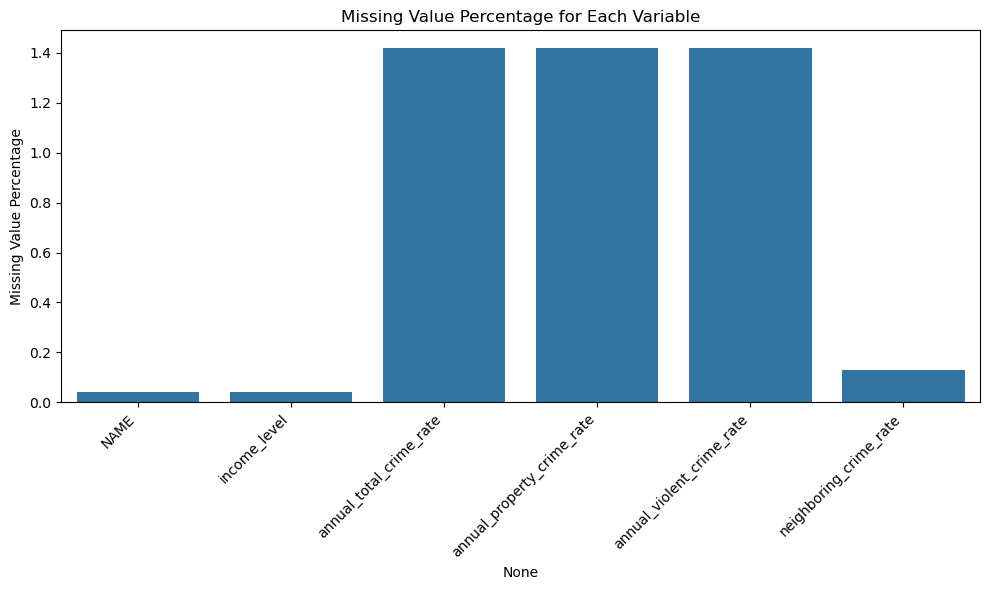


3. Data Statistical Summary
              GEOID  Total_Population     Pop15t19     Pop20t24     Pop25t29  \
count  2.325000e+03       2325.000000  2325.000000  2325.000000  2325.000000   
mean   3.605503e+10       3786.748387   217.505376   265.647312   340.396989   
std    2.598099e+07       2051.962124   153.684775   199.520221   274.732422   
min    3.600500e+10          0.000000     0.000000     0.000000     0.000000   
25%    3.604703e+10       2348.000000   118.000000   146.000000   172.000000   
50%    3.604712e+10       3584.000000   186.000000   229.000000   279.000000   
75%    3.608104e+10       4932.000000   286.000000   340.000000   431.000000   
max    3.608599e+10      17222.000000  1782.000000  2446.000000  2815.000000   

          Pop15t29   income_level    area_sqkm  population_density  \
count  2325.000000    2324.000000  2325.000000         2325.000000   
mean    823.549677   81301.712995     3.622797         1898.195881   
std     546.183942   43792.559925     7.

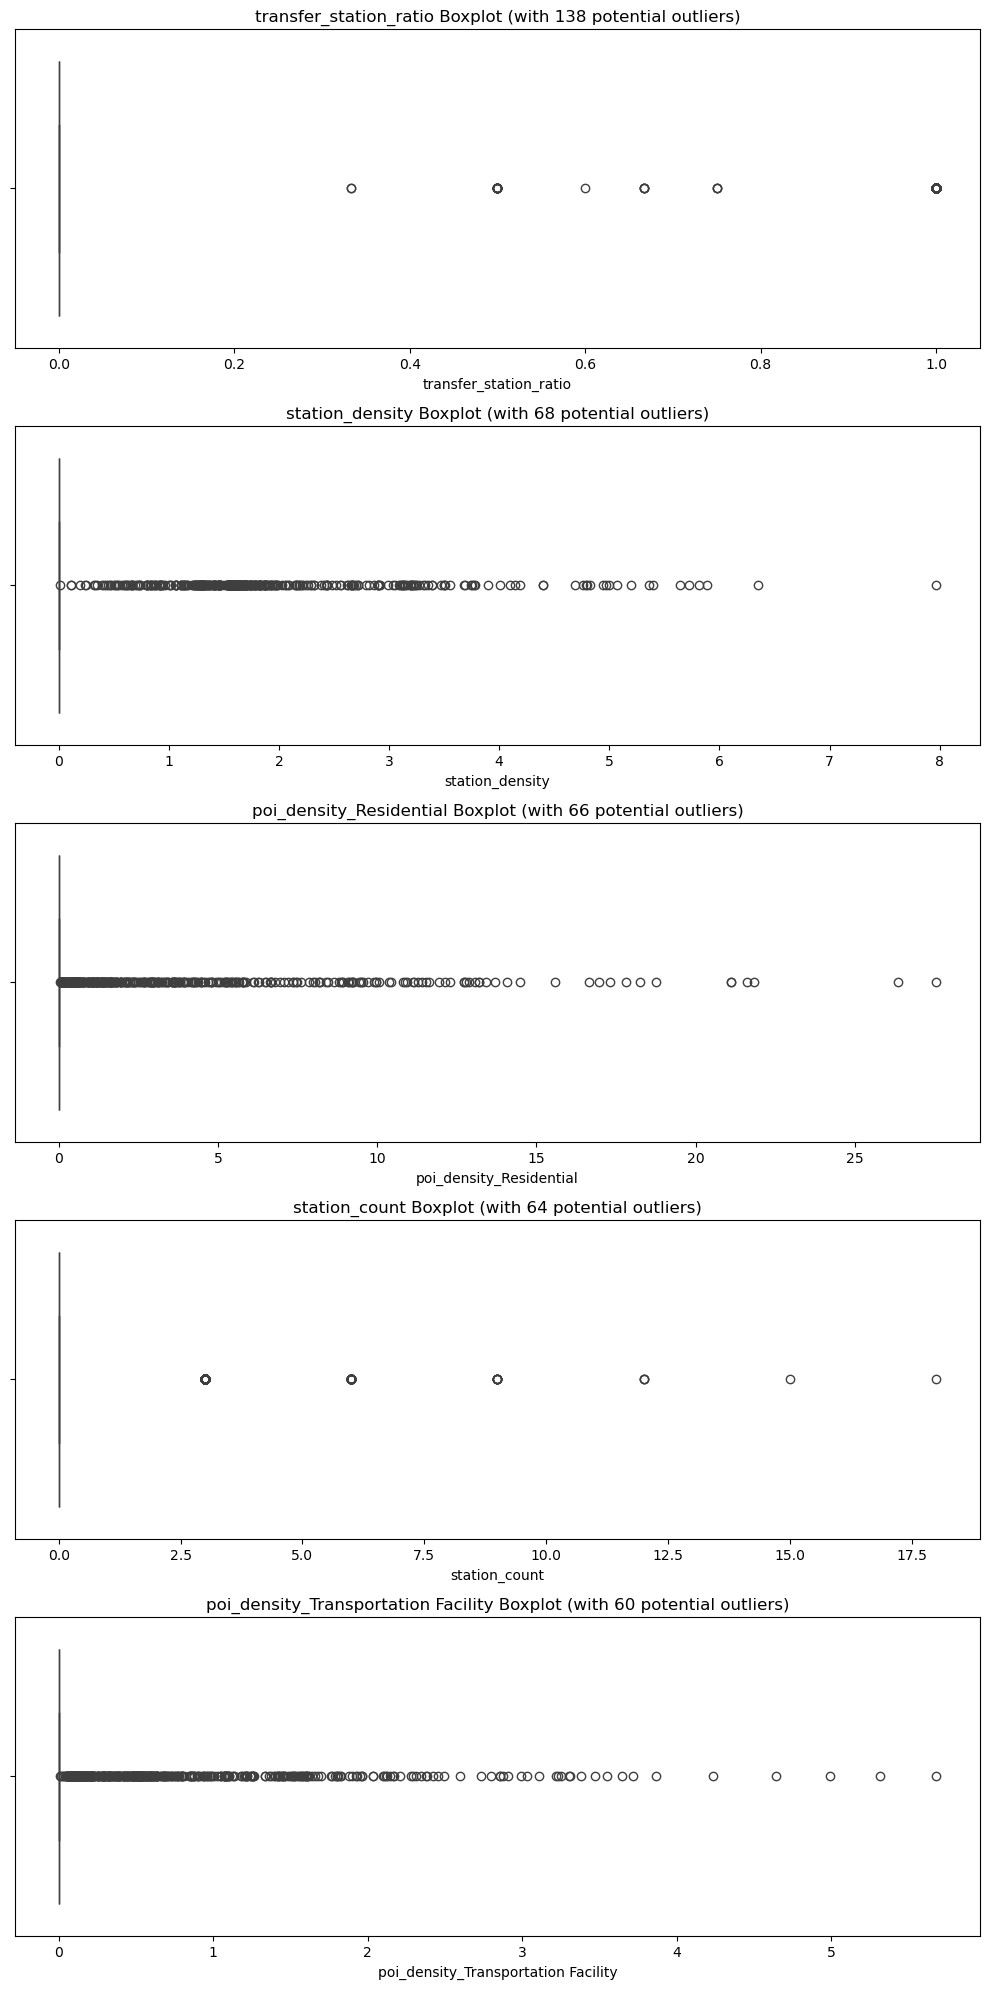

In [131]:
# Set matplotlib parameters to optimize display effects
plt.rcParams['axes.unicode_minus'] = False    # For properly displaying negative signs
plt.rcParams['figure.figsize'] = [12, 8]      # Set default chart size
plt.rcParams['figure.dpi'] = 100              # Set default DPI

# Create output directory
OUTPUT_DIR = "output/integrated_analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load integrated CT data
print("Loading CT integrated data...")
ct_data = pd.read_csv('processed_data/ct_integrated_data_by_population.csv')

# Process income features - switch to using a single income level variable
print("Using single income level variable instead of multiple income percentages")
# Check if income_level exists in the dataset
if 'income_level' in ct_data.columns:
    print(f"Income level variable found with {ct_data['income_level'].nunique()} unique values")
    # Show distribution of income levels
    income_value_counts = ct_data['income_level'].value_counts(dropna=False)
    print("Income level distribution:")
    print(income_value_counts)
else:
    print("Warning: income_level variable not found in dataset")

# Convert to GeoDataFrame for spatial visualization
try:
    # Attempt to convert geometry information from WKT strings
    ct_data['geometry'] = ct_data['geometry'].apply(wkt.loads)
    ct_gdf = gpd.GeoDataFrame(ct_data, geometry='geometry', crs="EPSG:4326")
    
    # Convert coordinate system to EPSG:2263 (NY State Plane coordinate system)
    ct_gdf = ct_gdf.to_crs("EPSG:2263")
    has_geometry = True
    print("Successfully converted to GeoDataFrame, and transformed to EPSG:2263 coordinate system")
except Exception as e:
    print(f"Unable to convert geometric data: {e}")
    print("Will only perform non-spatial analysis")
    ct_gdf = ct_data.copy()
    has_geometry = False

# 1. Basic Data Overview
print("\n1. Basic Data Overview")
print(f"Dataset dimensions: {ct_data.shape}")
print("\nData types:")
print(ct_data.dtypes)

# 2. Check for missing values
print("\n2. Check for missing values")
missing_values = ct_data.isnull().sum()
missing_percent = (missing_values / len(ct_data)) * 100
missing_df = pd.DataFrame({'Missing Value Count': missing_values, 'Missing Value Percentage': missing_percent})
missing_df_nonzero = missing_df[missing_df['Missing Value Count'] > 0]
if not missing_df_nonzero.empty:
    print(missing_df_nonzero)
    
    # Plot missing value chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_df_nonzero.index, y='Missing Value Percentage', data=missing_df_nonzero)
    plt.title('Missing Value Percentage for Each Variable')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/missing_values.png")
    plt.show()
else:
    print("No missing values in the data")

# 3. Data Statistical Summary
print("\n3. Data Statistical Summary")
# Select numerical columns for analysis
numeric_cols = ct_data.select_dtypes(include=[np.number]).columns.tolist()
summary_stats = ct_data[numeric_cols].describe()
print(summary_stats)
summary_stats.to_csv(f"{OUTPUT_DIR}/summary_statistics.csv")

# 4. Check and handle outliers
print("\n4. Check for outliers")
# Use Z-score method to detect outliers
outliers_count = {}
for col in numeric_cols:
    if ct_data[col].notna().all():
        z_scores = np.abs(stats.zscore(ct_data[col]))
        outliers = (z_scores > 3).sum()
        if outliers > 0:
            outliers_count[col] = outliers

print("Outlier statistics:")
for col, count in outliers_count.items():
    print(f"{col}: {count} potential outliers")

# Visualize boxplots for some key variables to show outliers
if outliers_count:
    # Select the top 5 variables with the most outliers
    top_outlier_cols = sorted(outliers_count.items(), key=lambda x: x[1], reverse=True)[:5]
    top_cols = [col for col, _ in top_outlier_cols]
    
    fig, axes = plt.subplots(len(top_cols), 1, figsize=(10, 4*len(top_cols)))
    if len(top_cols) == 1:
        axes = [axes]
    
    for i, col in enumerate(top_cols):
        sns.boxplot(x=ct_data[col], ax=axes[i])
        axes[i].set_title(f'{col} Boxplot (with {outliers_count[col]} potential outliers)')
        axes[i].set_xlabel(col)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/outliers_boxplots.png")
    plt.show()

### Correlation Analysis


 Correlation Analysis


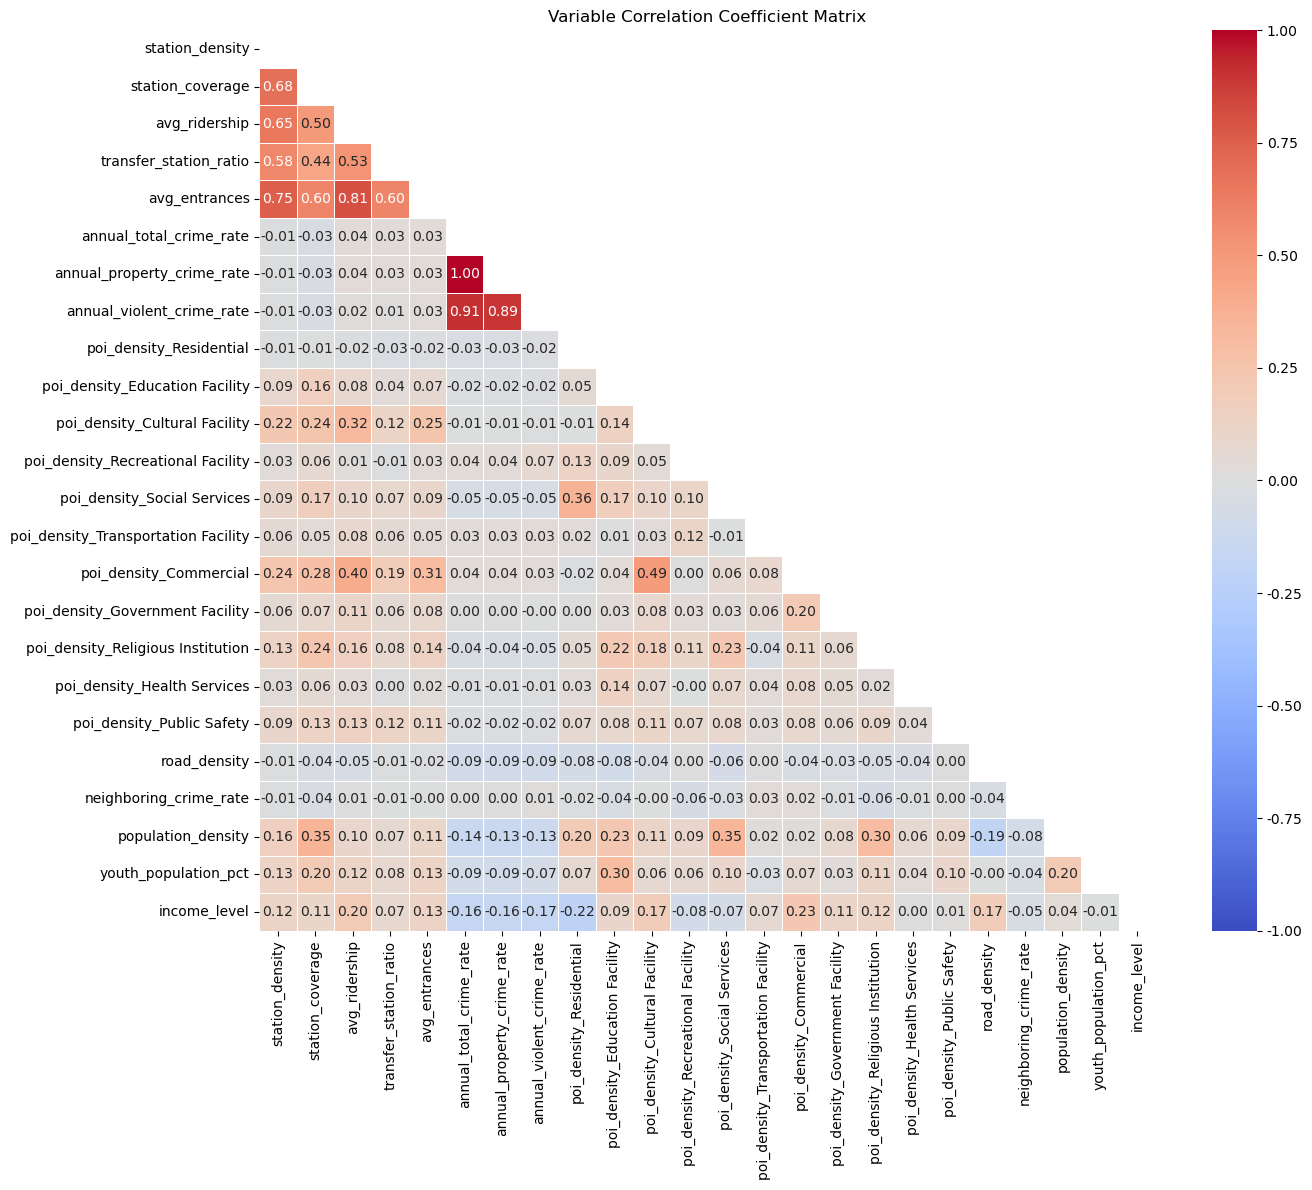

In [132]:
# Correlation Analysis
print("\n Correlation Analysis")
# Select main variables for correlation analysis, including income_level
corr_vars = [
    'station_density','station_coverage','avg_ridership','transfer_station_ratio', 'avg_entrances',
    'annual_total_crime_rate','annual_property_crime_rate', 'annual_violent_crime_rate',
    'poi_density_Residential', 'poi_density_Education Facility',
    'poi_density_Cultural Facility','poi_density_Recreational Facility',
    'poi_density_Social Services', 'poi_density_Transportation Facility',
    'poi_density_Commercial','poi_density_Government Facility',
    'poi_density_Religious Institution', 'poi_density_Health Services',
    'poi_density_Public Safety', 'road_density','neighboring_crime_rate',
    'population_density', 'youth_population_pct',
    'income_level'
]

# Ensure all selected variables exist
corr_vars = [col for col in corr_vars if col in ct_data.columns]

# Calculate correlation matrix
corr_matrix = ct_data[corr_vars].corr()

# Save correlation matrix
corr_matrix.to_csv(f"{OUTPUT_DIR}/correlation_matrix.csv")

# Plot heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create a mask to only show the lower triangle
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=0.5, mask=mask, vmin=-1, vmax=1)
plt.title('Variable Correlation Coefficient Matrix')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/correlation_heatmap.png")
plt.show()

#### Crime Analysis with Transit and Income 


 Analysis of Subway Station Features and Crime Relationship


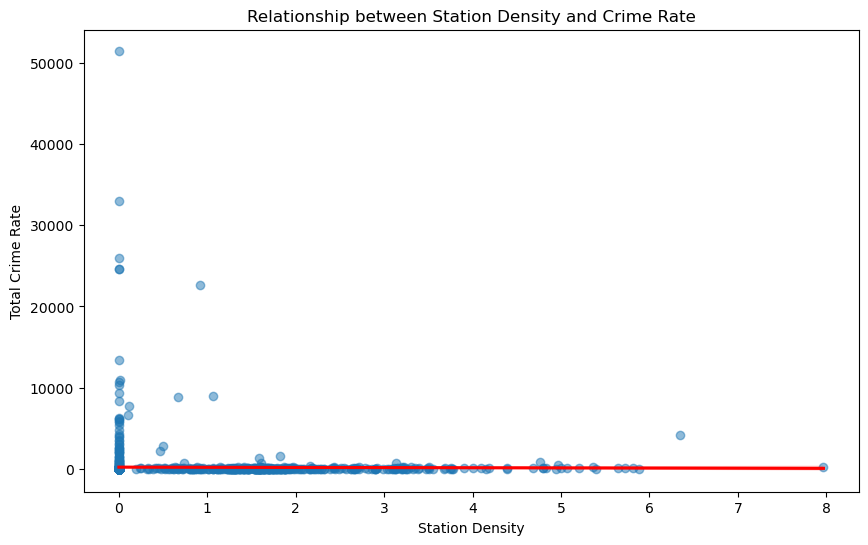

Correlation coefficient between station density and total crime density: -0.009


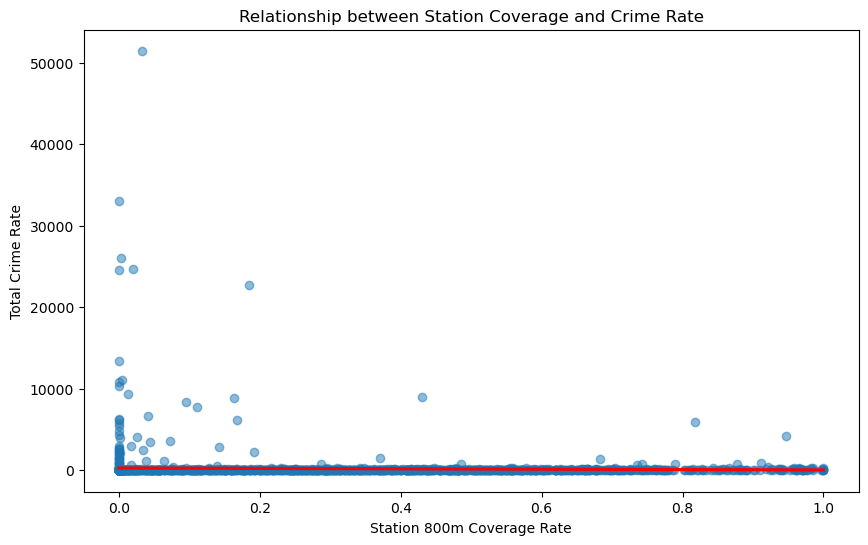

Correlation coefficient between station coverage and total crime density: -0.034


In [133]:
# Analysis of Subway Station Features and Crime Relationship
print("\n Analysis of Subway Station Features and Crime Relationship")
# Scatter plot of station density and crime density
if 'station_density' in ct_data.columns and 'annual_total_crime_rate' in ct_data.columns:
    plt.figure(figsize=(10, 6))
    sns.regplot(x='station_density', y='annual_total_crime_rate', data=ct_data, 
               scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title('Relationship between Station Density and Crime Rate')
    plt.xlabel('Station Density')
    plt.ylabel('Total Crime Rate')
    plt.savefig(f"{OUTPUT_DIR}/station_density_vs_crime.png")
    plt.show()
    
    # Calculate correlation coefficient
    corr = ct_data[['station_density', 'annual_total_crime_rate']].corr().iloc[0,1]
    print(f"Correlation coefficient between station density and total crime density: {corr:.3f}")

# Scatter plot of station coverage and crime density
if 'station_coverage' in ct_data.columns and 'annual_total_crime_rate' in ct_data.columns:
    plt.figure(figsize=(10, 6))
    sns.regplot(x='station_coverage', y='annual_total_crime_rate', data=ct_data, 
               scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title('Relationship between Station Coverage and Crime Rate')
    plt.xlabel('Station 800m Coverage Rate')
    plt.ylabel('Total Crime Rate')
    plt.savefig(f"{OUTPUT_DIR}/station_coverage_vs_crime.png")
    plt.show()
    
    # Calculate correlation coefficient
    corr = ct_data[['station_coverage', 'annual_total_crime_rate']].corr().iloc[0,1]
    print(f"Correlation coefficient between station coverage and total crime density: {corr:.3f}")



 Crime Type Comparison Analysis


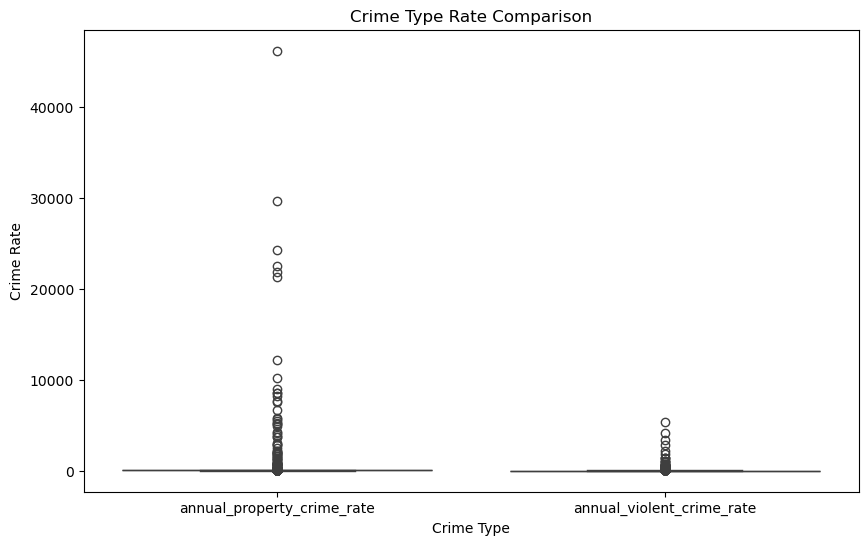

Average rate by crime type:
annual_property_crime_rate    177.837497
annual_violent_crime_rate      21.406338
dtype: float64
Correlation coefficient between property crime and violent crime rate: 0.892


In [136]:
# Crime Type Comparison Analysis
print("\n Crime Type Comparison Analysis")
if all(x in ct_data.columns for x in ['annual_property_crime_rate', 'annual_violent_crime_rate']):
    # Create crime type comparison boxplot
    crime_types = ct_data[['annual_property_crime_rate', 'annual_violent_crime_rate']]
    crime_melted = pd.melt(crime_types, var_name='Crime Type', value_name='Rate')
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Crime Type', y='Rate', data=crime_melted)
    plt.title('Crime Type Rate Comparison')
    plt.xlabel('Crime Type')
    plt.ylabel('Crime Rate')
    plt.savefig(f"{OUTPUT_DIR}/crime_types_comparison.png")
    plt.show()
    
    # Calculate mean comparison
    mean_stats = crime_types.mean()
    print("Average rate by crime type:")
    print(mean_stats)
    
    # Crime type correlation
    crime_corr = crime_types.corr().iloc[0,1]
    print(f"Correlation coefficient between property crime and violent crime rate: {crime_corr:.3f}")



Income and Crime Relationship Analysis


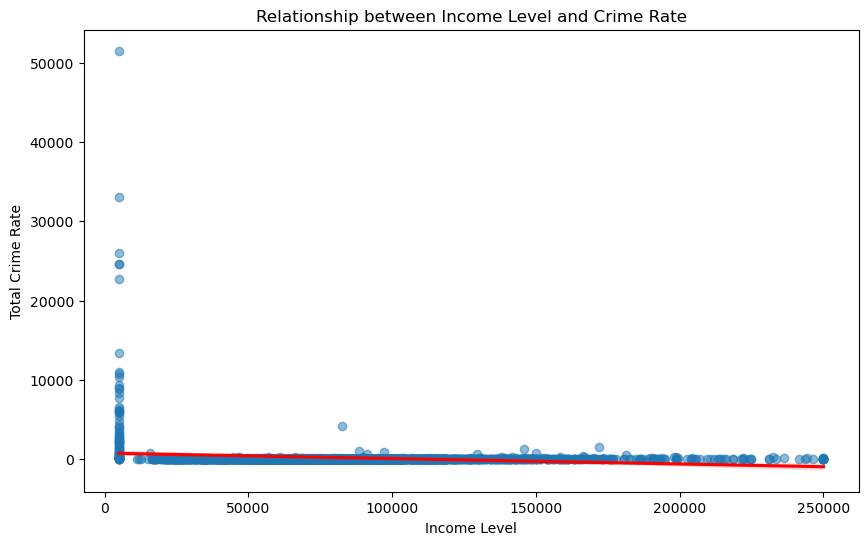

Correlation coefficient between income level and total crime density: -0.164

Income and Transit Equity Analysis


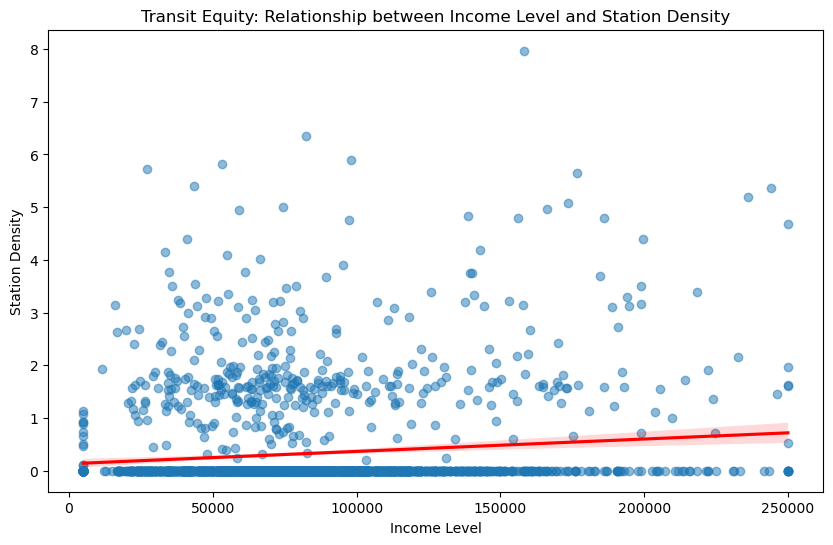

Correlation coefficient between income level and station density: 0.120
Positive correlation suggests higher income areas have better transit access


In [137]:
# Income and Crime Relationship Analysis - using a single income level variable
print("\nIncome and Crime Relationship Analysis")
if 'income_level' in ct_data.columns and 'annual_total_crime_rate' in ct_data.columns:
    plt.figure(figsize=(10, 6))
    sns.regplot(x='income_level', y='annual_total_crime_rate', data=ct_data, 
               scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title('Relationship between Income Level and Crime Rate')
    plt.xlabel('Income Level')
    plt.ylabel('Total Crime Rate')
    plt.savefig(f"{OUTPUT_DIR}/income_level_vs_crime.png")
    plt.show()
    
    # Calculate correlation coefficient
    corr = ct_data[['income_level', 'annual_total_crime_rate']].corr().iloc[0,1]
    print(f"Correlation coefficient between income level and total crime density: {corr:.3f}")

# Income and Transit Equity Analysis - using a single income level variable
print("\nIncome and Transit Equity Analysis")
if 'income_level' in ct_data.columns and 'station_density' in ct_data.columns:
    # Plot relationship between income level and station density
    plt.figure(figsize=(10, 6))
    sns.regplot(x='income_level', y='station_density', data=ct_data, 
               scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title('Transit Equity: Relationship between Income Level and Station Density')
    plt.xlabel('Income Level')
    plt.ylabel('Station Density')
    plt.savefig(f"{OUTPUT_DIR}/income_level_vs_transit.png")
    plt.show()
    
    # Calculate correlation coefficient
    corr = ct_data[['income_level', 'station_density']].corr().iloc[0,1]
    print(f"Correlation coefficient between income level and station density: {corr:.3f}")
    
    # Interpret the direction of the correlation
    if corr > 0:
        print("Positive correlation suggests higher income areas have better transit access")
    elif corr < 0:
        print("Negative correlation suggests lower income areas have better transit access (better equity)")
    else:
        print("No correlation suggests equal transit access across income levels")


### Multicollinearity


 Check for multicollinearity
                               Variable        VIF
0                             Intercept  17.055875
1                       station_density   3.116335
2                      station_coverage   2.337148
3                         avg_ridership   3.295631
4                transfer_station_ratio   1.709213
5                         avg_entrances   4.164976
6               poi_density_Residential   1.243312
7        poi_density_Education Facility   1.221949
8         poi_density_Cultural Facility   1.401620
9     poi_density_Recreational Facility   1.071855
10          poi_density_Social Services   1.325710
11  poi_density_Transportation Facility   1.044596
12               poi_density_Commercial   1.556620
13      poi_density_Government Facility   1.061398
14    poi_density_Religious Institution   1.215038
15          poi_density_Health Services   1.033297
16            poi_density_Public Safety   1.053413
17                         road_density   1.102115
1

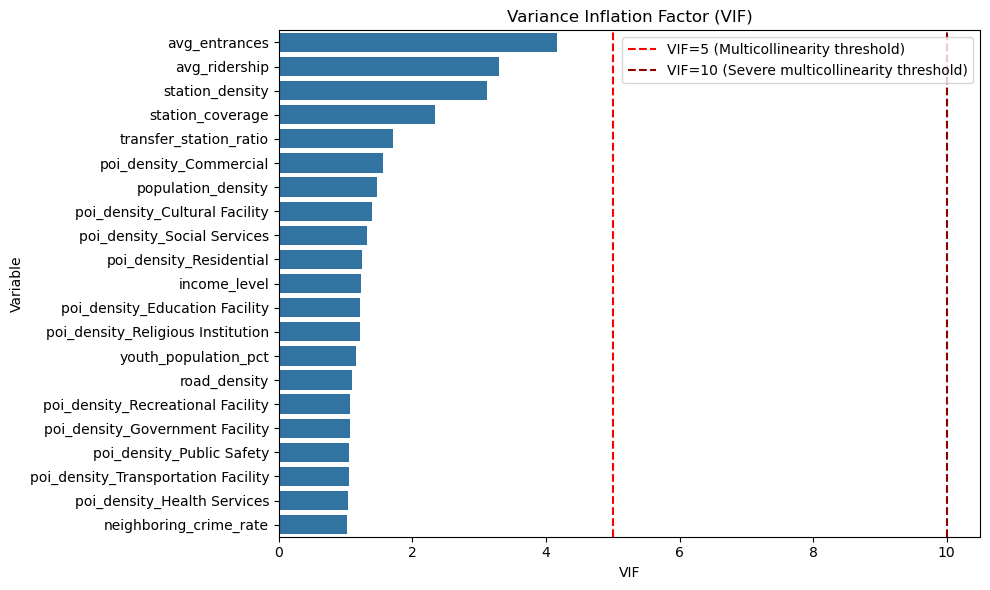

In [138]:
# Check for multicollinearity
print("\n Check for multicollinearity")
# Select independent variables, using income_level instead of income percentages
X_vars = [
    'station_density','station_coverage','avg_ridership','transfer_station_ratio', 'avg_entrances',
    'poi_density_Residential', 'poi_density_Education Facility',
    'poi_density_Cultural Facility','poi_density_Recreational Facility',
    'poi_density_Social Services', 'poi_density_Transportation Facility',
    'poi_density_Commercial','poi_density_Government Facility',
    'poi_density_Religious Institution', 'poi_density_Health Services',
    'poi_density_Public Safety', 'road_density','neighboring_crime_rate',
    'population_density', 'youth_population_pct',
    # 使用单一收入等级变量
    'income_level'
]

# Ensure all selected variables exist
X_vars = [col for col in X_vars if col in ct_data.columns]

# Remove missing values
X = ct_data[X_vars].dropna()

if not X.empty:
    # Create constant term
    X_with_const = pd.DataFrame({
        'Intercept': np.ones(len(X)),
        **{col: X[col] for col in X.columns}
    })
    
    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
    
    print(vif_data)
    vif_data.to_csv(f"{OUTPUT_DIR}/vif_values.csv", index=False)
    
    # Visualize VIF values
    plt.figure(figsize=(10, 6))
    vif_sorted = vif_data.sort_values('VIF', ascending=False)
    vif_sorted = vif_sorted[vif_sorted['Variable'] != 'Intercept']  # Remove intercept term
    sns.barplot(x='VIF', y='Variable', data=vif_sorted)
    plt.title('Variance Inflation Factor (VIF)')
    plt.axvline(x=5, color='r', linestyle='--', label='VIF=5 (Multicollinearity threshold)')
    plt.axvline(x=10, color='darkred', linestyle='--', label='VIF=10 (Severe multicollinearity threshold)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/vif_barplot.png")
    plt.show()


### Group Comparison Analysis


Group Comparison Analysis by Income Level

Crime density statistics by income level:
                    mean          std  count
income_group                                
Low           554.216468  3148.876041    734
Medium         29.771642   154.107605    790
High           34.330561    94.932957    767


/var/folders/78/73hgkmn13jjcw_dhfbc0tf4h0000gn/T/ipykernel_37140/1626314210.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_group_stats = ct_data.groupby('income_group')['annual_total_crime_rate'].agg(['mean', 'std', 'count'])


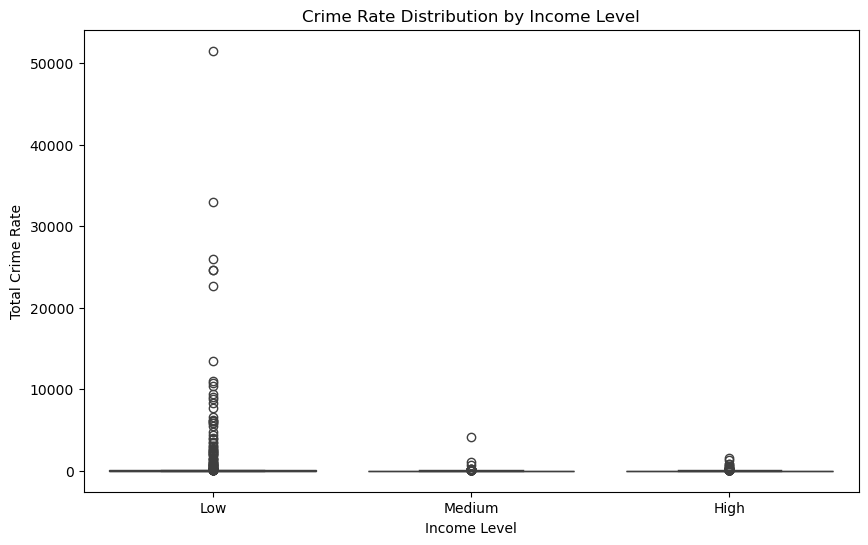

ANOVA results: F-statistic = 21.337, p-value = 0.00000
Conclusion: Crime density differences between income levels are statistically significant (p < 0.05)


In [139]:
# Group Comparison Analysis by Income Level - using integer-based income level variable
print("\nGroup Comparison Analysis by Income Level")
if 'income_level' in ct_data.columns and 'annual_total_crime_rate' in ct_data.columns:
    # Check the number of unique values in income_level to decide grouping strategy
    num_levels = ct_data['income_level'].nunique()
    
    # If income levels are numeric and there are multiple levels, proceed with grouping
    if num_levels > 0:
        # If the number of levels is greater than 5, use quantile-based binning
        if num_levels > 5:
            # Compute quantiles
            quantiles = ct_data['income_level'].quantile([0.33, 0.67]).tolist()
            bins = [ct_data['income_level'].min(), quantiles[0], quantiles[1], ct_data['income_level'].max()]
            labels = ['Low', 'Medium', 'High']
            
            ct_data['income_group'] = pd.cut(
                ct_data['income_level'],
                bins=bins,
                labels=labels,
                include_lowest=True
            )
        else:
            # If few levels, use them directly as group labels
            ct_data['income_group'] = ct_data['income_level'].astype(str)
        
        # Compute crime rate statistics by income group
        income_group_stats = ct_data.groupby('income_group')['annual_total_crime_rate'].agg(['mean', 'std', 'count'])
        print("\nCrime density statistics by income level:")
        print(income_group_stats)
        
        # Create boxplot for crime rate distribution by income group
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='income_group', y='annual_total_crime_rate', data=ct_data)
        plt.title('Crime Rate Distribution by Income Level')
        plt.xlabel('Income Level')
        plt.ylabel('Total Crime Rate')
        plt.savefig(f"{OUTPUT_DIR}/crime_by_income_level.png")
        plt.show()
        
        # Perform ANOVA to test for significant differences across groups
        try:
            from scipy.stats import f_oneway
            
            # Collect group data
            groups = []
            for level in ct_data['income_group'].unique():
                if pd.notna(level):  # Exclude NaN values
                    group_data = ct_data[ct_data['income_group'] == level]['annual_total_crime_rate'].dropna()
                    if len(group_data) > 0:
                        groups.append(group_data)
            
            if len(groups) >= 2:  # ANOVA requires at least two groups
                f_stat, p_value = f_oneway(*groups)
                print(f"ANOVA results: F-statistic = {f_stat:.3f}, p-value = {p_value:.5f}")
                if p_value < 0.05:
                    print("Conclusion: Crime density differences between income levels are statistically significant (p < 0.05)")
                else:
                    print("Conclusion: Crime density differences between income levels are not statistically significant (p >= 0.05)")
        except Exception as e:
            print(f"ANOVA analysis error: {e}")



Group Comparison Analysis by Station Coverage

Crime density statistics by subway coverage group:
                      mean          std  count
coverage_level                                
Low             263.518449  2185.111182   1524
Medium           60.178744   462.612833    390
High             83.584771   384.321436    378


/var/folders/78/73hgkmn13jjcw_dhfbc0tf4h0000gn/T/ipykernel_37140/2821568245.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coverage_group_stats = ct_data.groupby('coverage_level')['annual_total_crime_rate'].agg(['mean', 'std', 'count'])


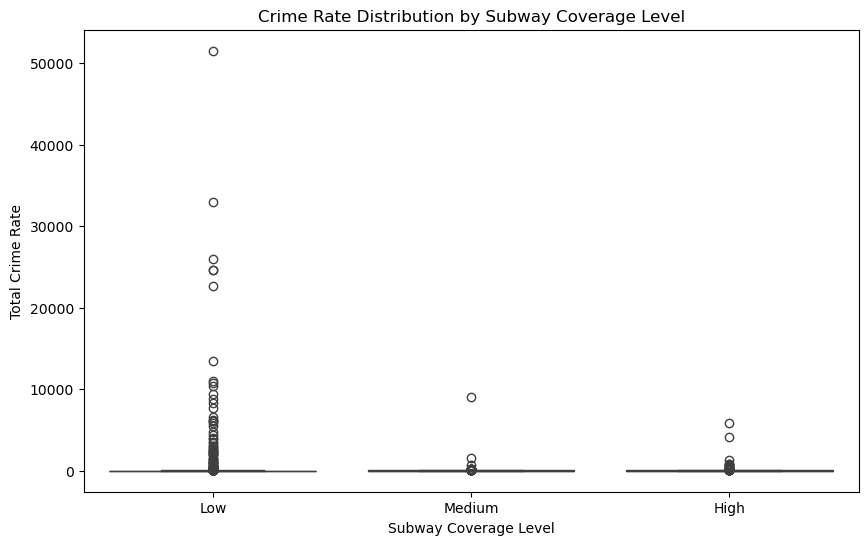

ANOVA results: F-statistic = 2.918, p-value = 0.05424
Conclusion: Crime density differences between subway coverage levels are not statistically significant (p >= 0.05)


In [140]:
# Group Comparison Analysis by Station Coverage
print("\nGroup Comparison Analysis by Station Coverage")
if 'station_coverage' in ct_data.columns and 'annual_total_crime_rate' in ct_data.columns:
    # Filter non-zero coverage values
    non_zero_coverage = ct_data['station_coverage'][ct_data['station_coverage'] > 0]
    
    if len(non_zero_coverage) > 0:
        try:
            # Use fixed proportion quantiles (33rd and 67th percentiles)
            quantiles = non_zero_coverage.quantile([0.33, 0.67]).tolist()
            # Define bins using min, quantiles, and max
            bins = [0, quantiles[0], quantiles[1], non_zero_coverage.max()]
            # Ensure bin edges are unique and sorted
            bins = sorted(list(set(bins)))
            
            # Only proceed if there are enough distinct bin edges
            if len(bins) >= 3:
                # Match label count to number of bins - 1
                labels = ['Low', 'Medium', 'High'][:len(bins)-1]
                
                ct_data['coverage_level'] = pd.cut(
                    ct_data['station_coverage'],
                    bins=bins,
                    labels=labels,
                    include_lowest=True
                )
                
                # Calculate mean, std, count of crime rate by subway coverage group
                coverage_group_stats = ct_data.groupby('coverage_level')['annual_total_crime_rate'].agg(['mean', 'std', 'count'])
                print("\nCrime density statistics by subway coverage group:")
                print(coverage_group_stats)
                
                # Create boxplot for crime rate by subway coverage group
                plt.figure(figsize=(10, 6))
                sns.boxplot(x='coverage_level', y='annual_total_crime_rate', data=ct_data)
                plt.title('Crime Rate Distribution by Subway Coverage Level')
                plt.xlabel('Subway Coverage Level')
                plt.ylabel('Total Crime Rate')
                plt.savefig(f"{OUTPUT_DIR}/crime_by_station_coverage_level.png")
                plt.show()
                
                # Perform ANOVA to test if differences between groups are significant
                try:
                    from scipy.stats import f_oneway
                    
                    # Collect group data
                    groups = []
                    for level in labels:
                        group_data = ct_data[ct_data['coverage_level'] == level]['annual_total_crime_rate'].dropna()
                        if len(group_data) > 0:
                            groups.append(group_data)
                    
                    if len(groups) >= 2:
                        f_stat, p_value = f_oneway(*groups)
                        print(f"ANOVA results: F-statistic = {f_stat:.3f}, p-value = {p_value:.5f}")
                        if p_value < 0.05:
                            print("Conclusion: Crime density differences between subway coverage levels are statistically significant (p < 0.05)")
                        else:
                            print("Conclusion: Crime density differences between subway coverage levels are not statistically significant (p >= 0.05)")
                except Exception as e:
                    print(f"ANOVA analysis error: {e}")
            else:
                print("Not enough different subway coverage values to perform meaningful grouping")
        except Exception as e:
            print(f"Subway coverage grouping analysis error: {e}")
    else:
        print("No positive subway coverage values in the data")
